#### Import packages

In [26]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
import warnings
warnings.filterwarnings('ignore')
import scipy

In [2]:
import os              
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

#### Read matrix 

In [11]:
raw = pd.read_csv("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/scNov/hAC_RSEC_MolsPerCell.csv",header=6,index_col=0)

In [14]:
adata = sc.AnnData(raw)

In [16]:
adata.raw = adata

#### Basic Filtering

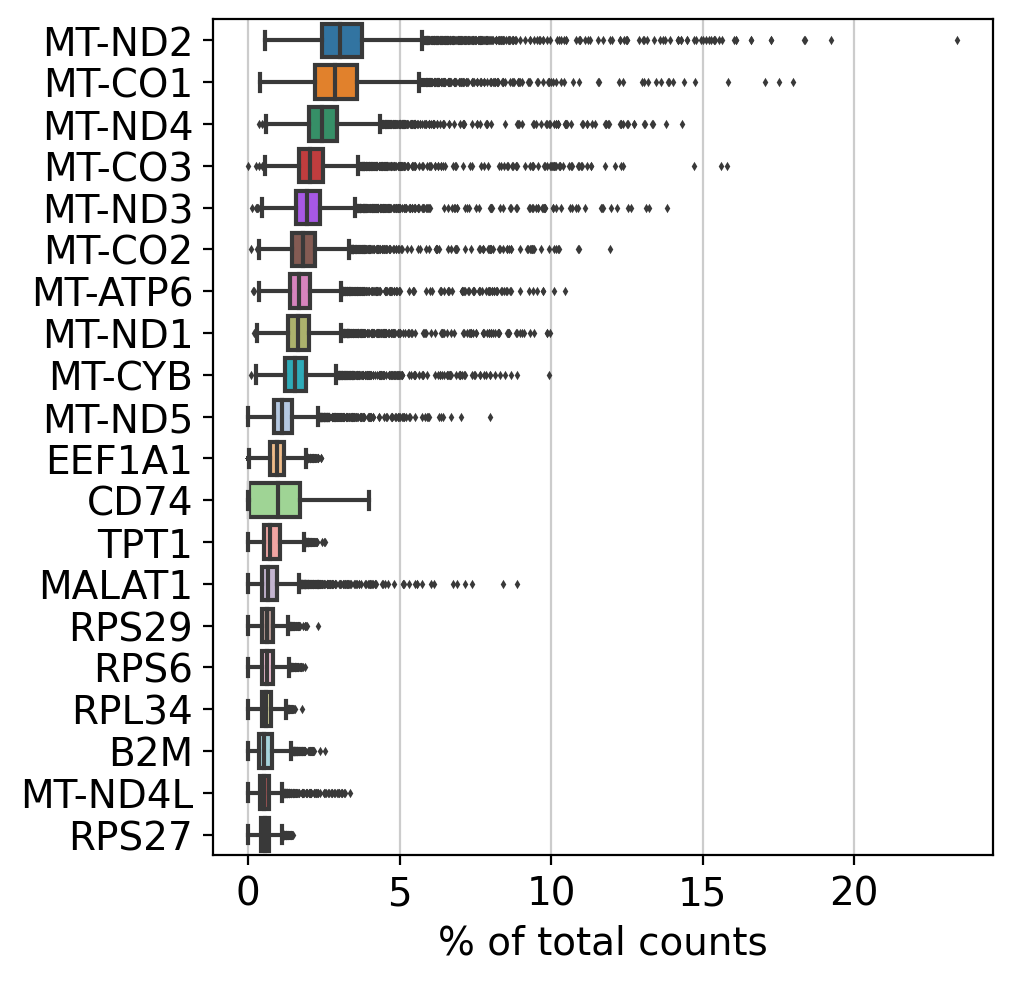

In [17]:
sc.pl.highest_expr_genes(adata,n_top=20)

In [18]:
adata.var_names_make_unique() 

In [19]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [21]:
adata

AnnData object with n_obs × n_vars = 7817 × 16961
    obs: 'n_genes'
    var: 'n_cells'

#### Remove doublets

<7817x16961 sparse matrix of type '<class 'numpy.float32'>'
	with 8411864 stored elements in Compressed Sparse Row format>

In [28]:
scrub = scr.Scrublet(scipy.sparse.csr_matrix(adata.X), expected_doublet_rate=0.06)

In [29]:
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.31
Detected doublet rate = 2.1%
Estimated detectable doublet fraction = 46.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 4.5%
Elapsed time: 7.3 seconds


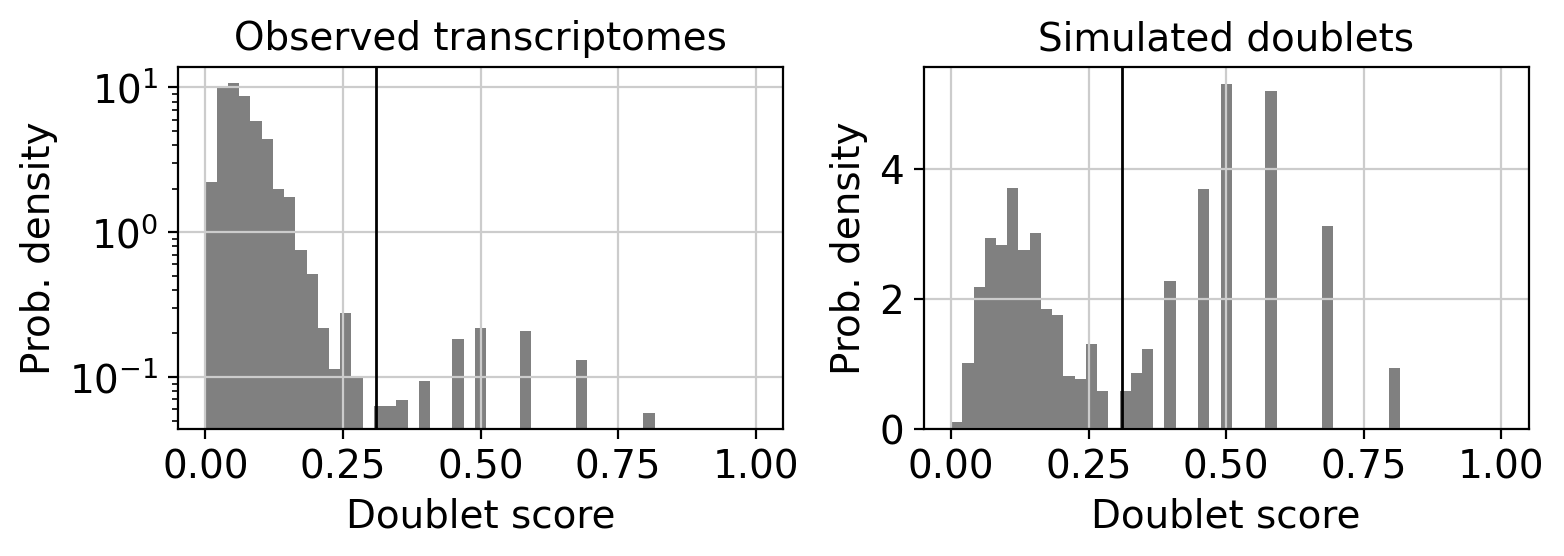

In [30]:
scrub.plot_histogram();

#### Annotate mithocondrial genes as 'mt' and calculate qc metrics

In [32]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')

In [33]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#### Annotate disaggregation genes as 'disaggregation_score' and calculate qc metrics

In [34]:
adata.var['disaggregation_score'] = adata.var_names.str.startswith(("ATF3", "BTG2", "CEBPB", "CEBPD", "CXCL3", "CXCL2", "CXCL1", "DNAJA1", "DNAJB1", "DUSP1", "EGR1", "FOS", "FOSB", "HSP90AA1", "HSP90AB1", "HSPA1A", "HSPA1B", "HSPA1A", "HSPA1B", "HSPA8", "HSPB1", "HSPE1", "HSPH1", "ID3", "IER2", "JUN", "JUNB", "JUND", "MT1X", "NFKBIA", "NR4A1", "PPP1R15A", "SOCS3", "ZFP36"))

In [35]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['disaggregation_score'], percent_top=None, log1p=False, inplace=True)

#### Annotate ribosomal genes as 'rp' and calculate qc metrics

In [36]:
adata.var['rb'] = adata.var_names.str.startswith('RPL')

In [37]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

#### Plot QC with some metrics

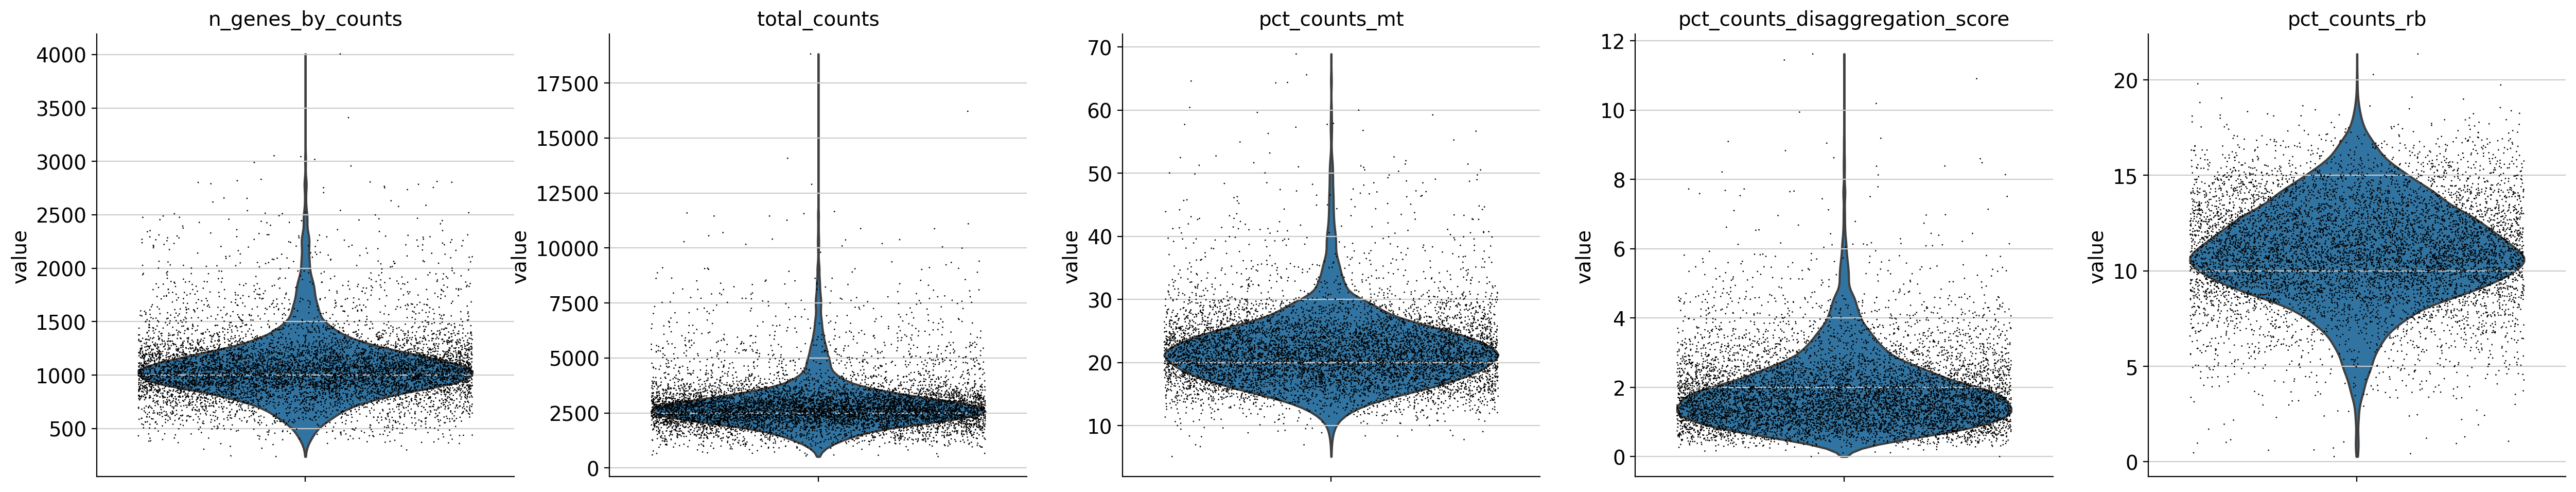

In [38]:
sc.pl.violin(adata,['n_genes_by_counts','total_counts','pct_counts_mt','pct_counts_disaggregation_score','pct_counts_rb'],jitter=0.4,multi_panel=True)

#### Plot histogram of a single variable

<AxesSubplot:xlabel='total_counts', ylabel='Density'>

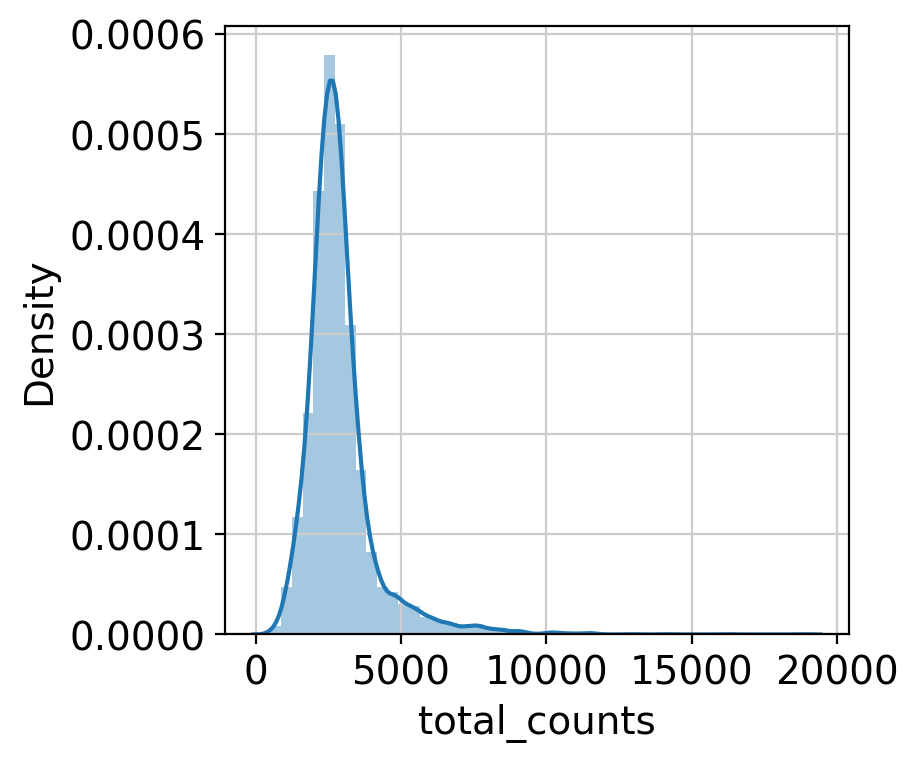

In [39]:
sb.distplot(adata.obs['total_counts'])

<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Density'>

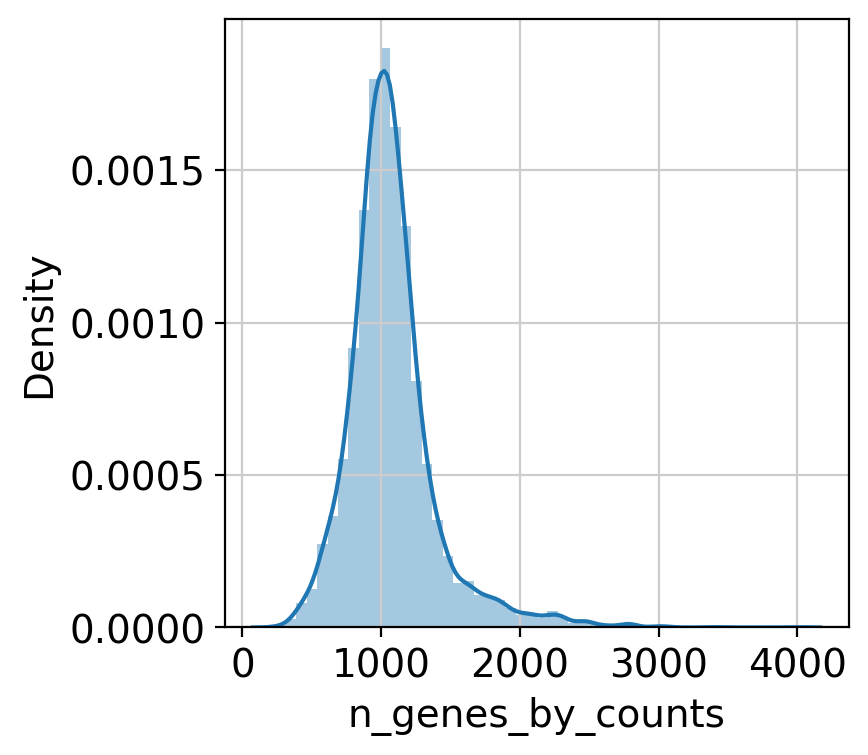

In [40]:
sb.distplot(adata.obs['n_genes_by_counts'])

<AxesSubplot:xlabel='pct_counts_mt', ylabel='Density'>

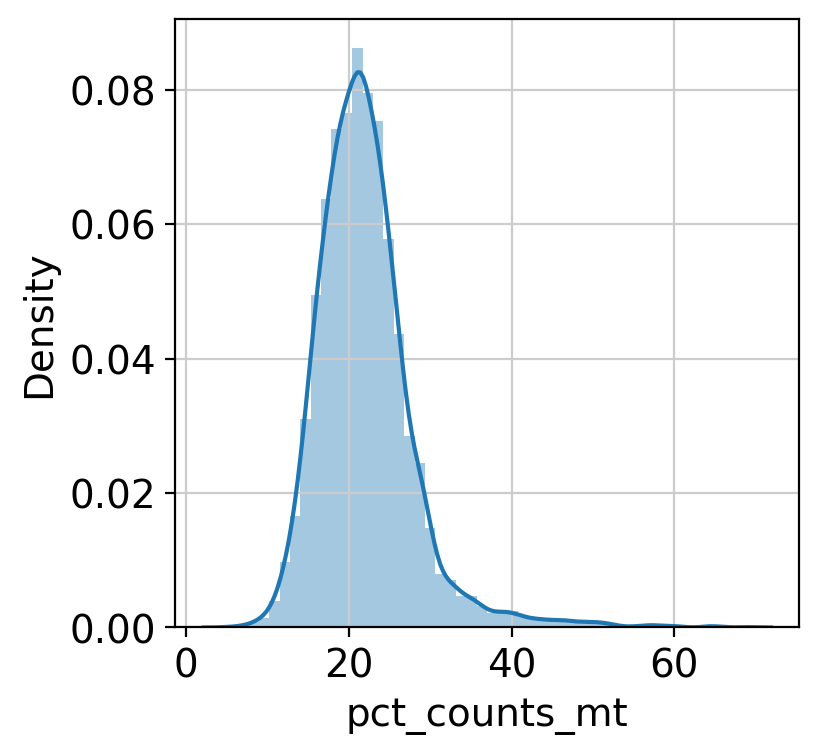

In [41]:
sb.distplot(adata.obs['pct_counts_mt'])

<AxesSubplot:xlabel='pct_counts_disaggregation_score', ylabel='Density'>

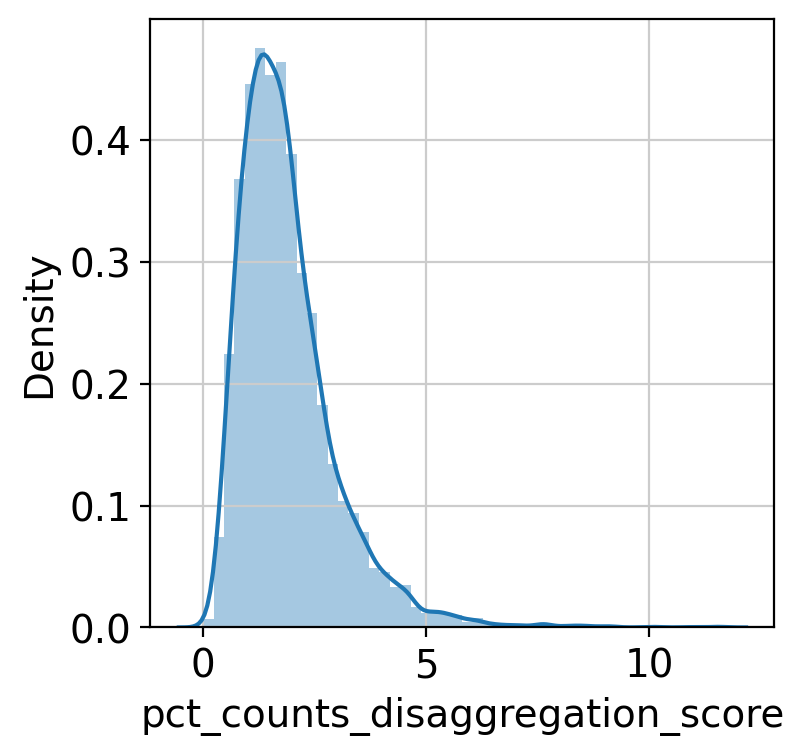

In [42]:
sb.distplot(adata.obs['pct_counts_disaggregation_score'])

<AxesSubplot:xlabel='pct_counts_rb', ylabel='Density'>

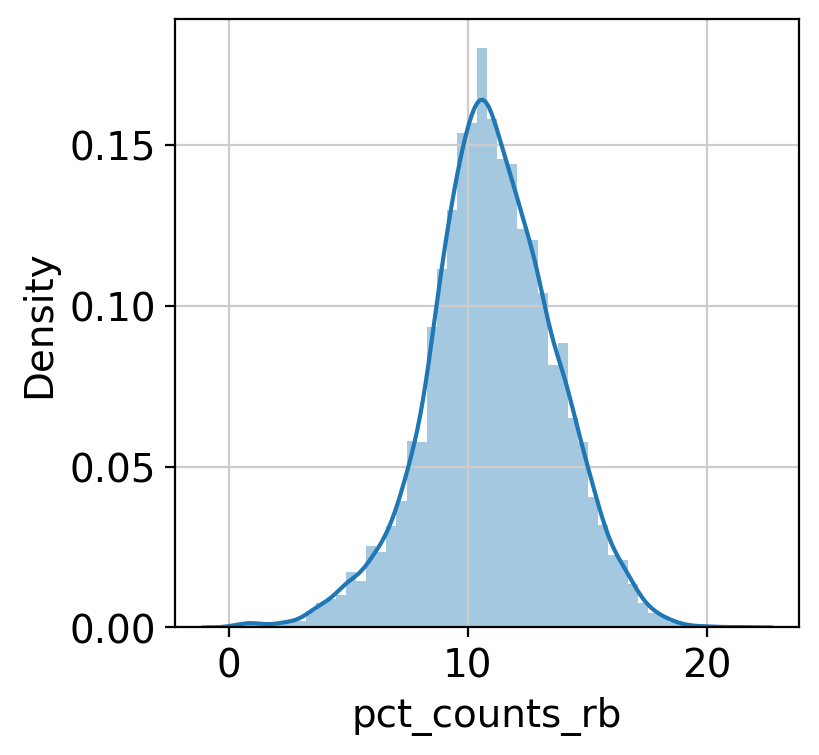

In [43]:
sb.distplot(adata.obs['pct_counts_rb'])

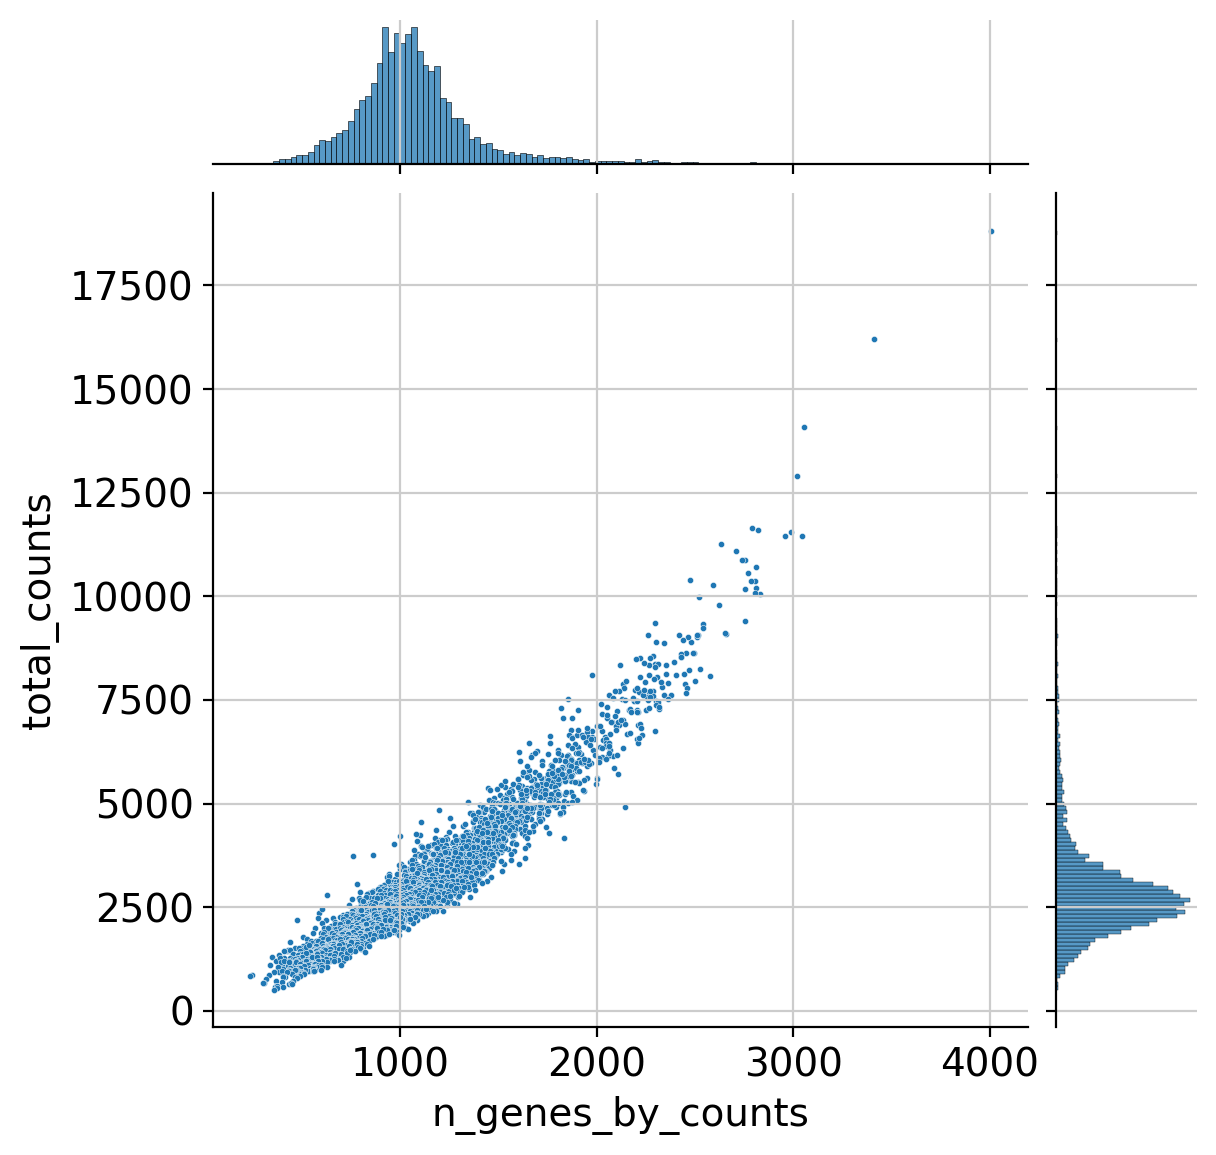

In [44]:
sb.jointplot(x="n_genes_by_counts",y="total_counts",data=adata.obs, kind="scatter", s=5)

#### Advanced Filtering

In [48]:
tmp = adata
tmp = tmp[tmp.obs.n_genes_by_counts < 2500, :]
tmp = tmp[tmp.obs.total_counts < 8000, :]
tmp = tmp[tmp.obs.pct_counts_mt < 35, :]
tmp = tmp[tmp.obs.pct_counts_disaggregation_score < 5, :]

In [49]:
tmp.shape

(7386, 16961)

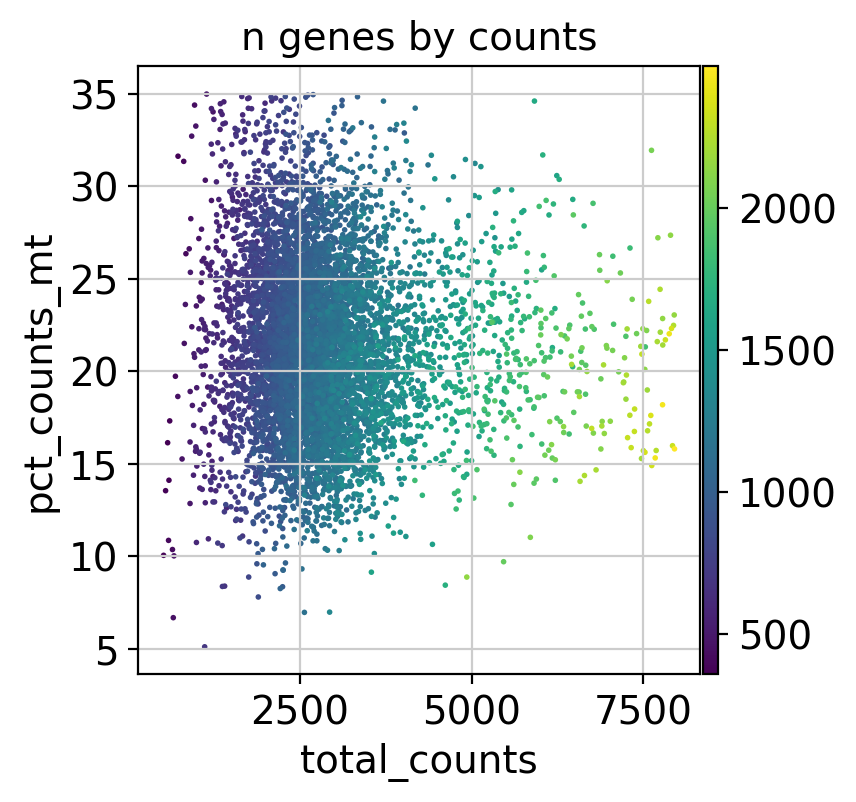

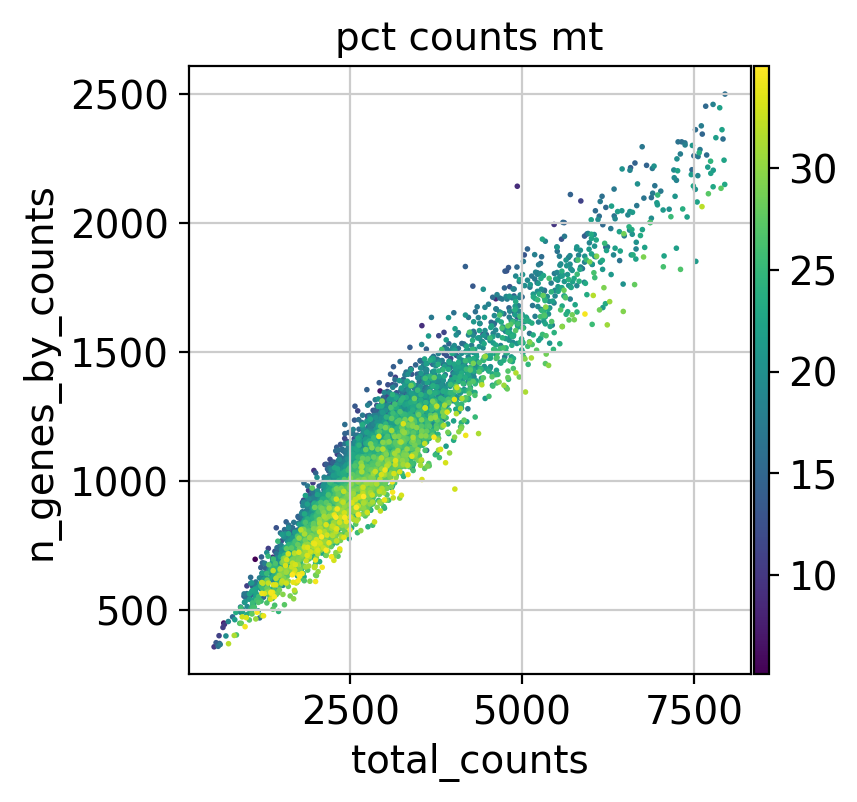

In [50]:
sc.pl.scatter(tmp, x='total_counts', y='pct_counts_mt', color = 'n_genes_by_counts')
sc.pl.scatter(tmp, x='total_counts', y='n_genes_by_counts', color = 'pct_counts_mt')

In [52]:
adata.obs['predicted_doublets'].value_counts()

False    7654
True      163
Name: predicted_doublets, dtype: int64

In [58]:
adata = adata[adata.obs['predicted_doublets'].isin([False]),:]

In [59]:
adata.shape

(7654, 16961)

#### Normalization (cpm)

In [60]:
norm_data = adata.copy()

In [61]:
sc.pp.normalize_total(norm_data, target_sum=1e4)

In [62]:
adata.layers['norm_data'] = norm_data.X.copy()

#### log n+1 transform

In [63]:
sc.pp.log1p(norm_data)

In [64]:
adata.layers['log1p'] = norm_data.X

#### identify higly variable genes

In [65]:
adata.layers

Layers with keys: norm_data, log1p

In [66]:
sc.pp.highly_variable_genes(adata,layer="log1p")

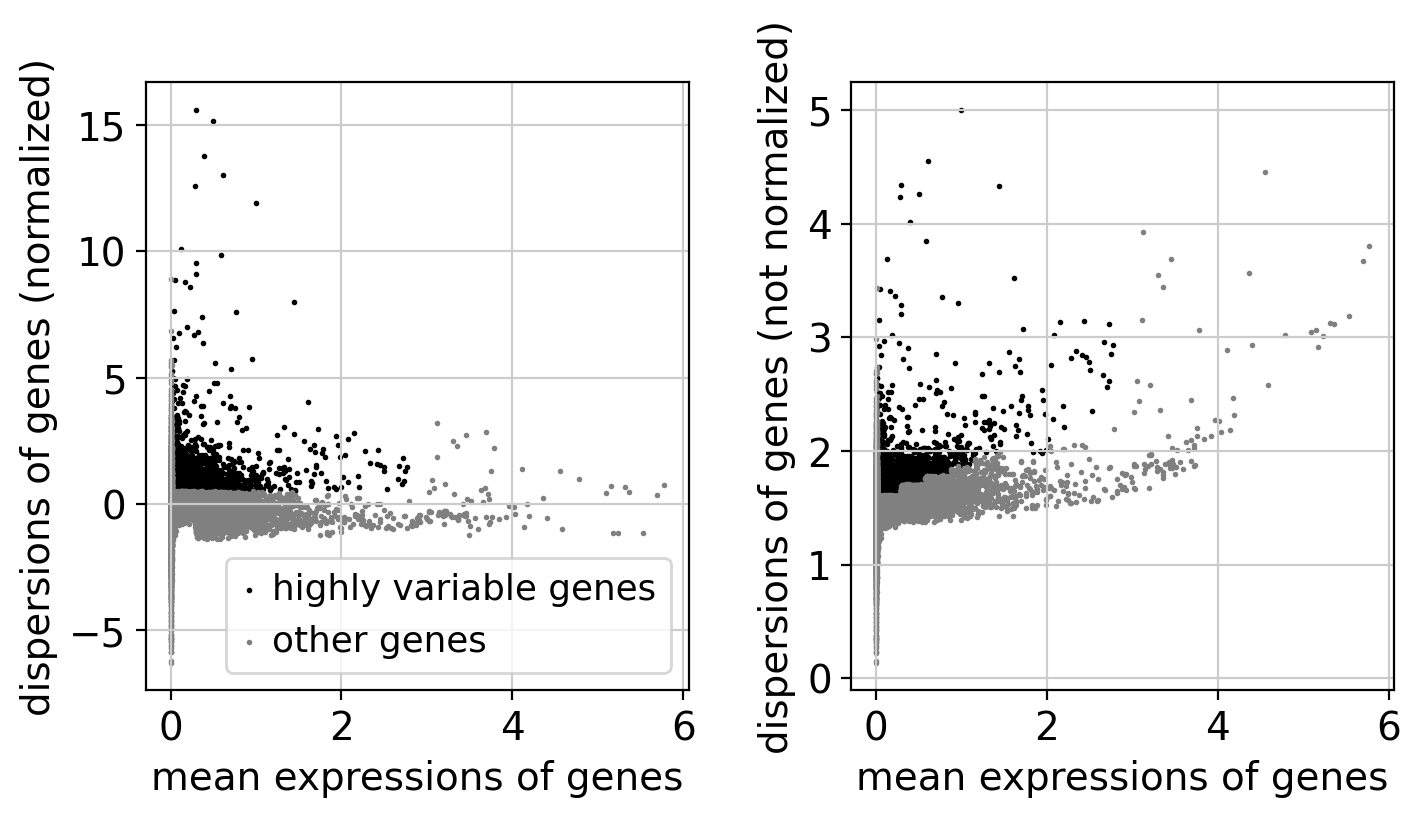

In [67]:
sc.pl.highly_variable_genes(adata)

#### Scaling

In [72]:
adata.layers['scaled'] = sc.pp.scale(adata, max_value=6, layer="log1p",copy=True).layers['log1p']

#### Cell Cycle Score

In [73]:
cell_cycle_genes = [x.strip() for x in open('/home/spuccio/isilon/spuccio/SP035_TregIntegration/Analysis/regev_lab_cell_cycle_genes_homo.txt')]

In [74]:
s_genes = cell_cycle_genes[:40]
g2m_genes = cell_cycle_genes[40:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [75]:
adata_cc_genes = adata.copy()

In [76]:
adata_cc_genes.raw = adata_cc_genes

In [77]:
adata_cc_genes = sc.tl.score_genes_cell_cycle(adata_cc_genes, s_genes=s_genes,g2m_genes=g2m_genes,use_raw=True,copy=True)

In [78]:
adata_cc_genes.X = adata_cc_genes.layers['scaled']

In [79]:
sc.tl.pca(adata_cc_genes,svd_solver='arpack',copy=False)

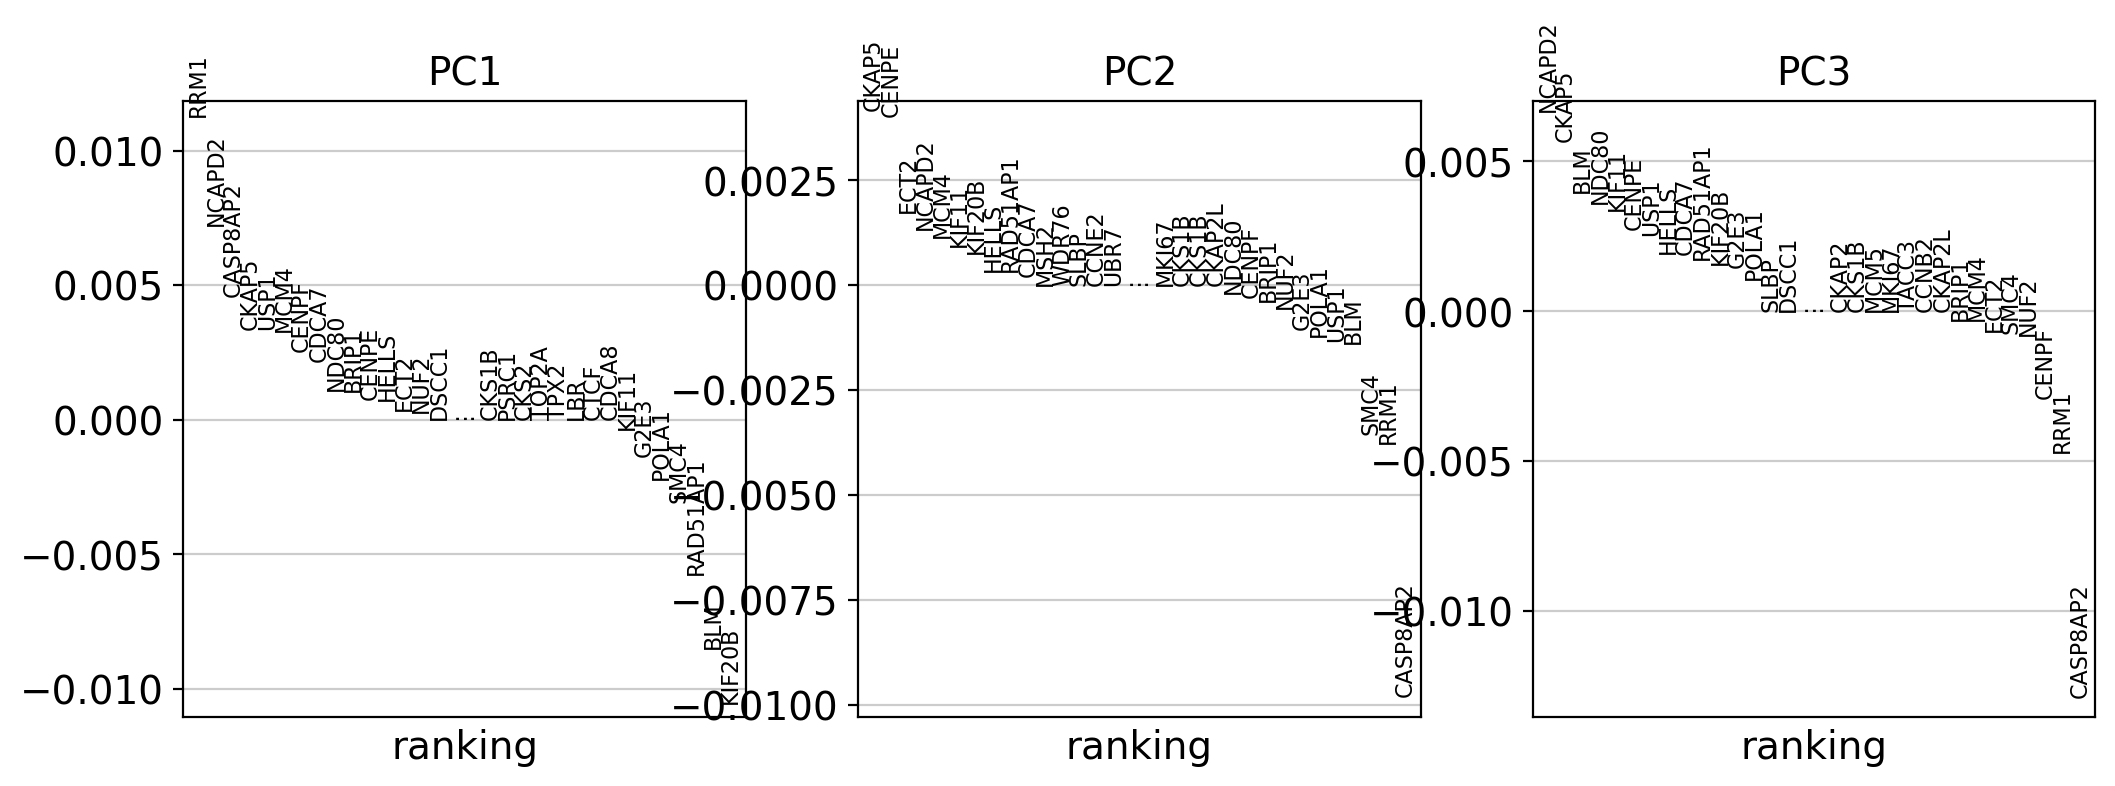

In [80]:
sc.pl.pca_loadings(adata_cc_genes[:, cell_cycle_genes])

... storing 'phase' as categorical


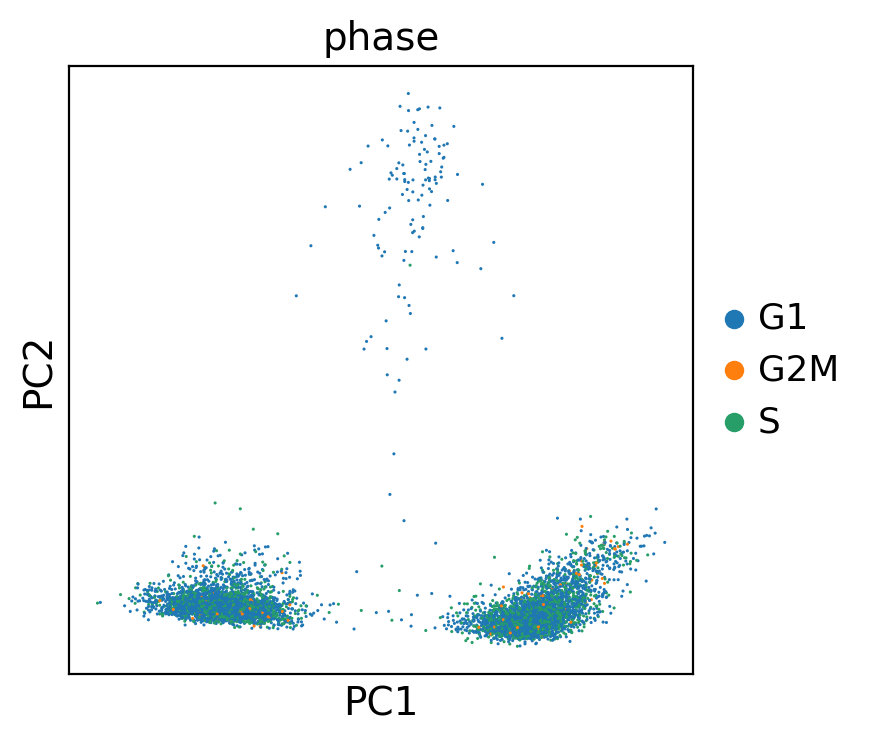

In [81]:
sc.pl.pca_scatter(adata_cc_genes, color='phase',s=5)

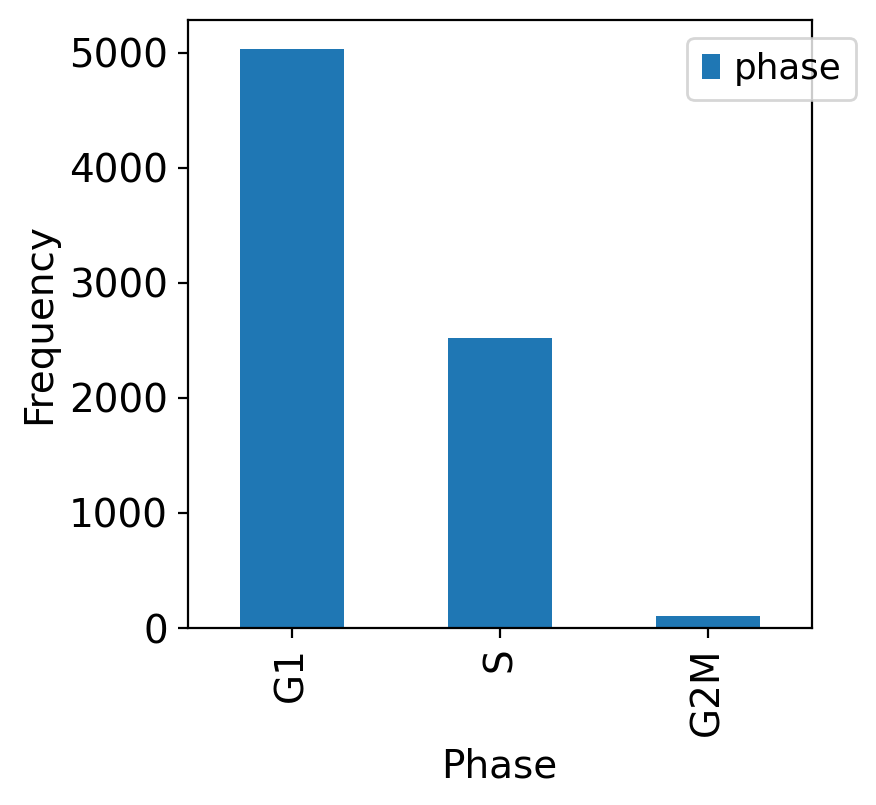

In [82]:
fig, (ax1) = plt.subplots(1,1)
ax1 = adata_cc_genes.obs["phase"].value_counts(normalize=False).plot.bar(legend=False,ax=ax1)
ax1.set_xlabel("Phase")
ax1.set_ylabel("Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

In [83]:
print(adata_cc_genes.obs["phase"].value_counts(normalize=True))
print(adata_cc_genes.obs["phase"].value_counts(normalize=False))

G1     0.657826
S      0.328978
G2M    0.013196
Name: phase, dtype: float64
G1     5035
S      2518
G2M     101
Name: phase, dtype: int64


In [84]:
adata.obs = adata_cc_genes.obs

In [85]:
adata.obs

n_genes  doublet_scores  predicted_doublets  n_genes_by_counts  \
Cell_Index                                                                   
333143         4006        0.057541               False               4006   
588810         3410        0.139767               False               3410   
221140         3019        0.034719               False               3019   
330402         2990        0.107797               False               2990   
704958         2791        0.099617               False               2791   
...             ...             ...                 ...                ...   
672487          401        0.007989               False                401   
541956          360        0.019837               False                360   
153826          371        0.018066               False                371   
666758          374        0.019837               False                374   
203000          358        0.017501               False                358   

            total_counts  total_counts_mt  pct_counts_mt  \
Cell_Index                                                 
333143           18821.0           3533.0      18.771584   
588810           16215.0           3261.0      20.111008   
221140           12895.0           2894.0      22.442808   
330402           11559.0           2137.0      18.487759   
704958           11658.0           2263.0      19.411562   
...                  ...              ...            ...   
672487             589.0             64.0      10.865874   
541956             576.0             93.0      16.145832   
153826             595.0             84.0      14.117648   
666758             546.0             74.0      13.553114   
203000             517.0             52.0      10.058026   

            total_counts_disaggregation_score  \
Cell_Index                                      
333143                                  172.0   
588810                                  265.0   
221140                                  336.0   
330402                                  408.0   
704958                                  173.0   
...                                       ...   
672487                                    5.0   
541956                                   18.0   
153826                                   22.0   
666758                                    2.0   
203000                                   11.0   

            pct_counts_disaggregation_score  total_counts_rb  pct_counts_rb  \
Cell_Index                                                                    
333143                             0.913873           1230.0       6.535253   
588810                             1.634289           2121.0      13.080481   
221140                             2.605661           1224.0       9.492051   
330402                             3.529717            829.0       7.171901   
704958                             1.483960           1439.0      12.343455   
...                                     ...              ...            ...   
672487                             0.848896             25.0       4.244482   
541956                             3.125000             35.0       6.076389   
153826                             3.697479             50.0       8.403361   
666758                             0.366300             27.0       4.945055   
203000                             2.127660             31.0       5.996131   

             S_score  G2M_score phase  
Cell_Index                             
333143      2.549514   1.968456     S  
588810     -0.187437  -0.747096    G1  
221140     -0.072537  -0.596391    G1  
330402     -0.249607  -0.385342    G1  
704958     -0.154941  -0.563628    G1  
...              ...        ...   ...  
672487     -0.007937  -0.025030    G1  
541956     -0.018519  -0.042908    G1  
153826     -0.009259  -0.019652    G1  
666758     -0.014550   0.004185   G2M  
203000     -0.026455  -0.027414    G1  

[7654 rows x 14 columns]

#### PCA

In [86]:
adata.X = adata.layers['scaled']

In [87]:
sc.tl.pca(adata,svd_solver='arpack',copy=False)

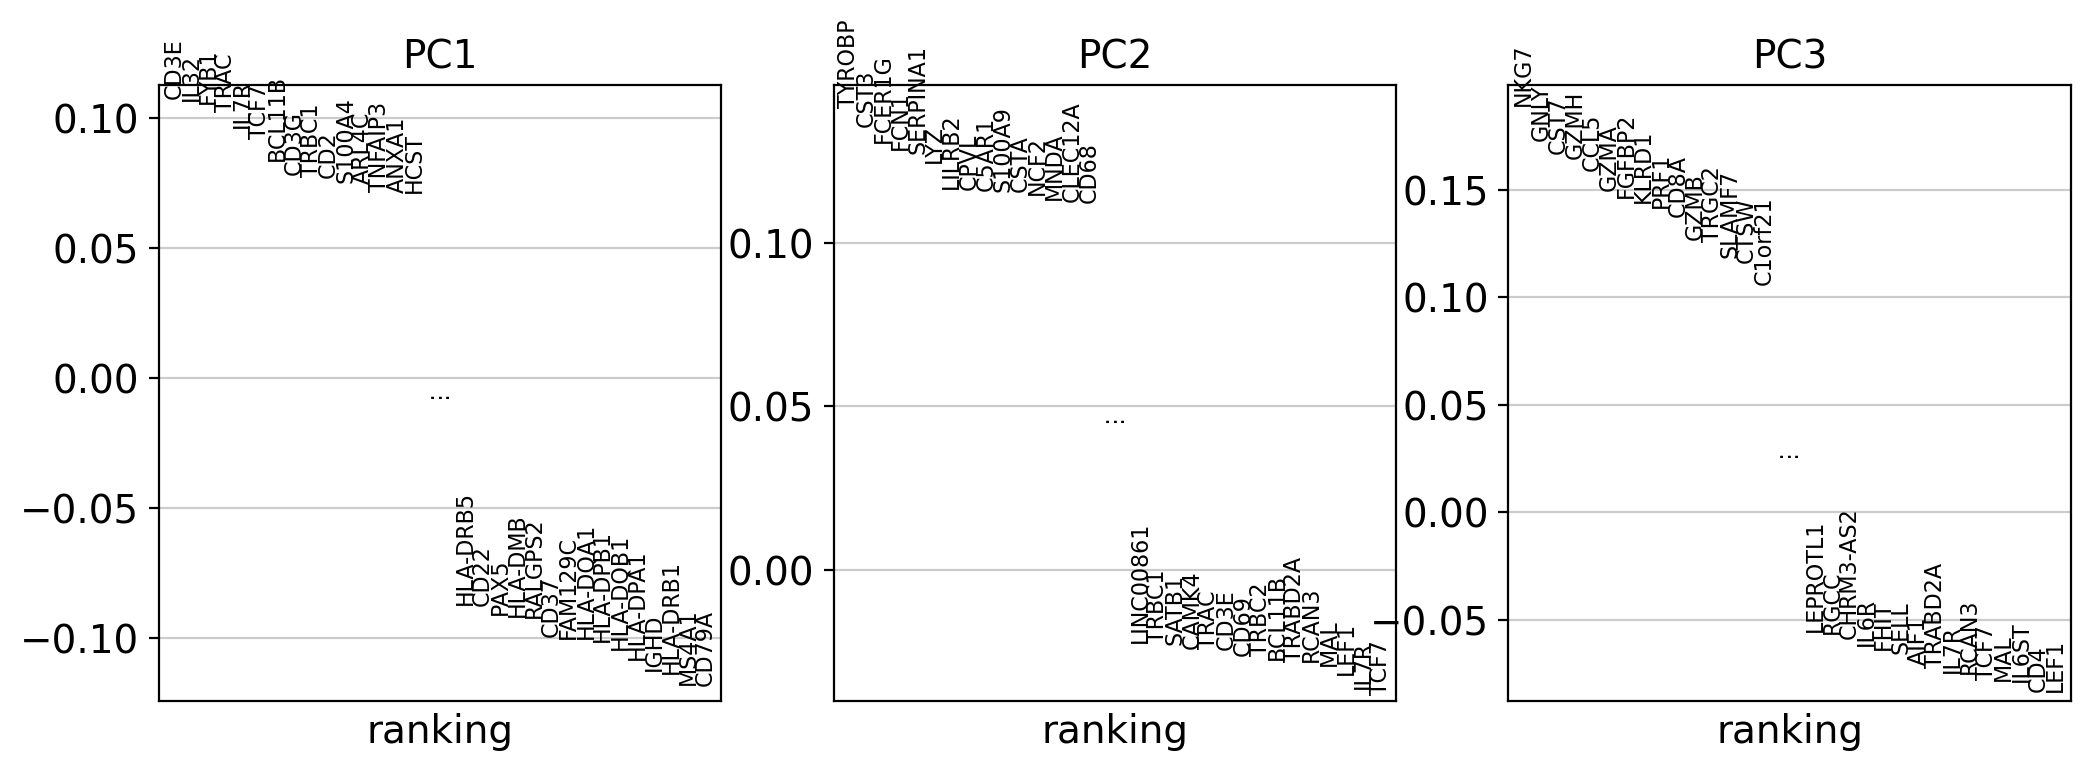

In [88]:
sc.pl.pca_loadings(adata)

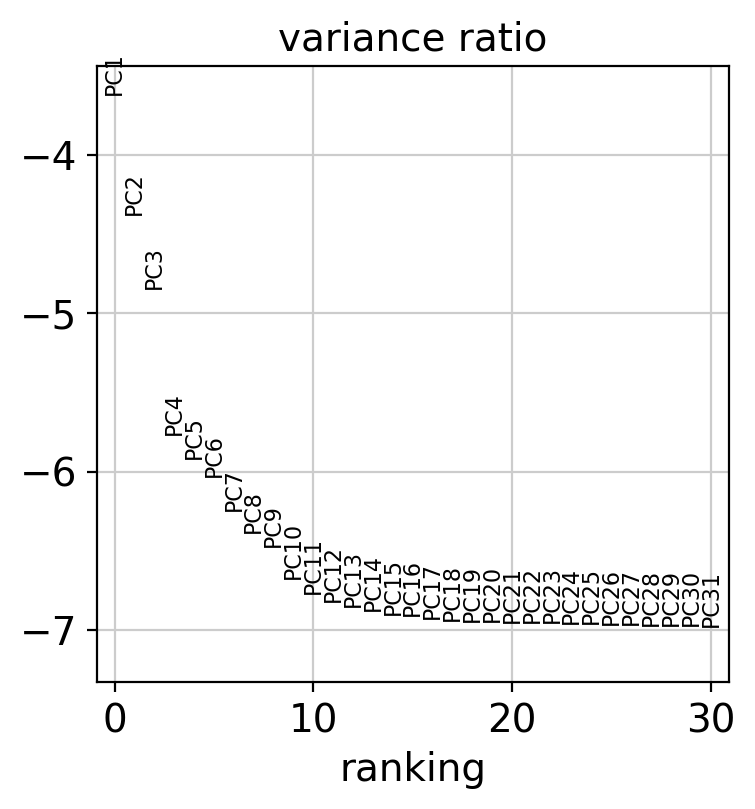

In [89]:
sc.pl.pca_variance_ratio(adata,log=True)

In [96]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import DistanceMetric
from sklearn.decomposition import PCA
from kneed import KneeLocator as kl

In [90]:
def PCA_elbox_fit(data):
    model = PCA().fit(data)
    explanied_variance = model.explained_variance_ratio_
    pcs = list(range(1,explanied_variance.shape[0]+1))
    klm = kl(pcs, explanied_variance,S=1.0, curve='convex',direction="decreasing")
    pcs_used = klm.knee
    pc_list = list(range(1,pcs_used+1))
    new_data = PCA(n_components=pcs_used,svd_solver="arpack").fit_transform(data)
    return pcs_used, new_data,pcs, explanied_variance,pc_list

In [91]:
HVG_data = adata[:,adata.var.highly_variable]

In [92]:
label = "HVG_data"

In [93]:
new_frame = pd.DataFrame(HVG_data.X.toarray(),index=HVG_data.obs_names,columns=HVG_data.var_names)

In [94]:
pandas_data = new_frame.values

In [97]:
dim,new_matrix, pc_ax,pc_ay,col_labels = PCA_elbox_fit(pandas_data)

In [98]:
print(dim)

18


In [99]:
columns = ["PC_"+str(i) for i in col_labels]

In [100]:
outputpath = "/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/scNov/"

In [101]:
PC_frame = pd.DataFrame(new_matrix, index=new_frame.index.values.tolist(),columns=columns)

In [102]:
PC_frame.shape

(7654, 18)

Text(0, 0.5, 'Explained variance Ratio')

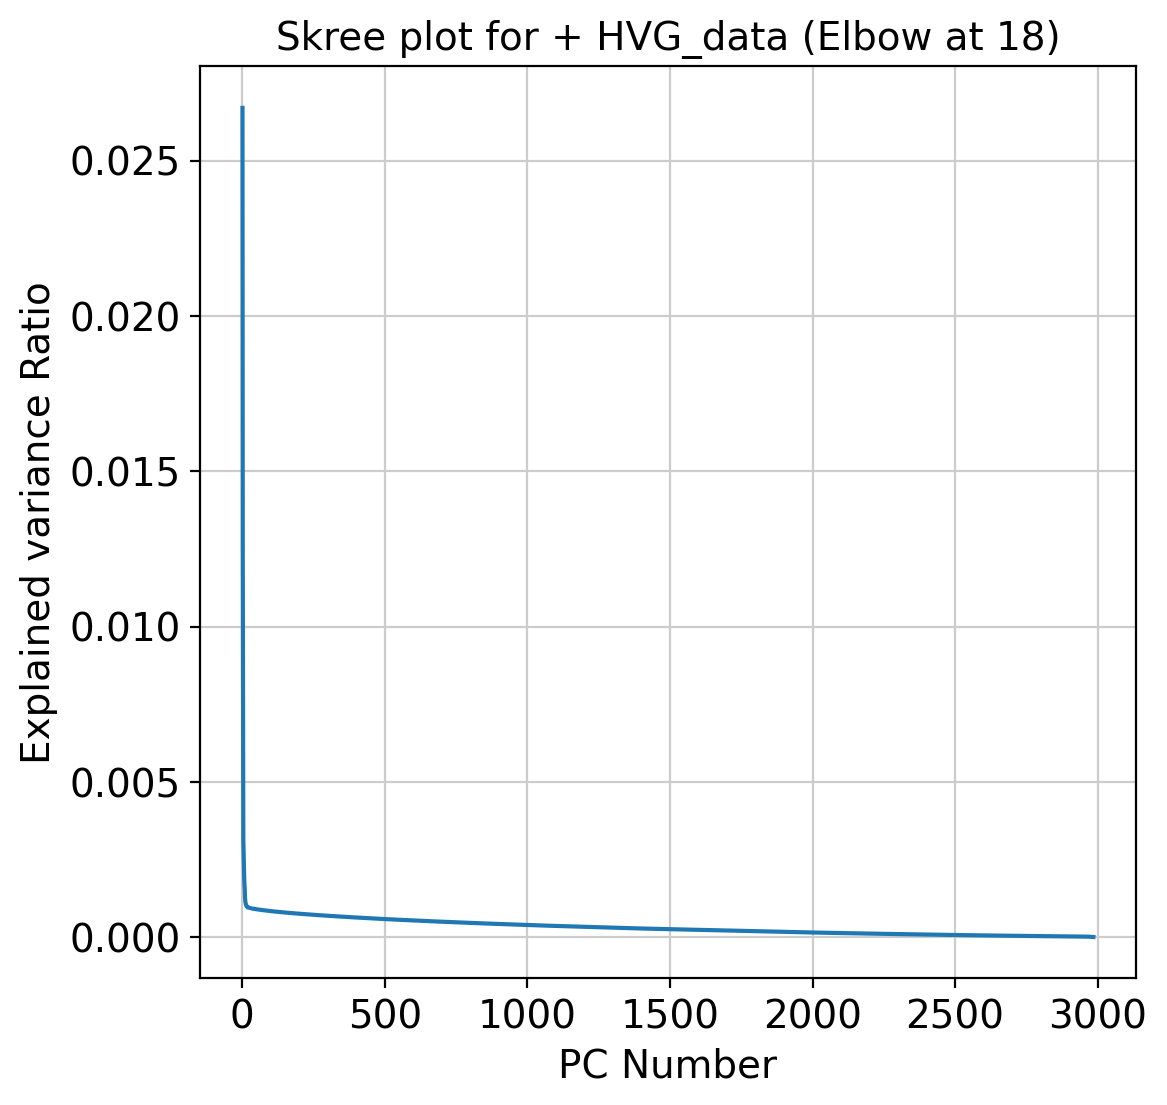

In [104]:
fig = plt.figure(figsize = (6,6,))
ax1 = fig.add_subplot(111)
ax1.set_title("Skree plot for + "+label+" (Elbow at "+str(dim)+")")
ax1.plot(pc_ax,pc_ay)
ax1.set_xlabel("PC Number")
ax1.set_ylabel("Explained variance Ratio")


#### Cell classification

In [105]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=dim)

In [106]:
sc.tl.umap(adata)

In [107]:
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)

In [108]:
import celltypist
from celltypist import models

In [109]:
models.download_models(force_update = True)

📜 Retrieving model list from server https://celltypist.cog.sanger.ac.uk/models/models.json
📚 Total models in list: 7
📂 Storing models in /home/spuccio/.celltypist/data/models
💾 Downloading model [1/7]: Immune_All_Low.pkl
💾 Downloading model [2/7]: Immune_All_High.pkl
💾 Downloading model [3/7]: Immune_All_PIP.pkl
💾 Downloading model [4/7]: Immune_All_AddPIP.pkl
💾 Downloading model [5/7]: Cells_Intestinal_Tract.pkl
💾 Downloading model [6/7]: Cells_Lung_Airway.pkl
💾 Downloading model [7/7]: Nuclei_Lung_Airway.pkl


In [110]:
model = models.Model.load(model = 'Immune_All_High.pkl')

In [115]:
adata.X = adata.layers['log1p']

In [116]:
predictions = celltypist.annotate(adata, model = 'Immune_All_High.pkl', majority_voting = True)

🔬 Input data has 7654 cells and 16961 genes
🔗 Matching reference genes in the model
🧬 1382 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [118]:
adata = predictions.to_adata()

In [119]:
sc.tl.umap(adata)

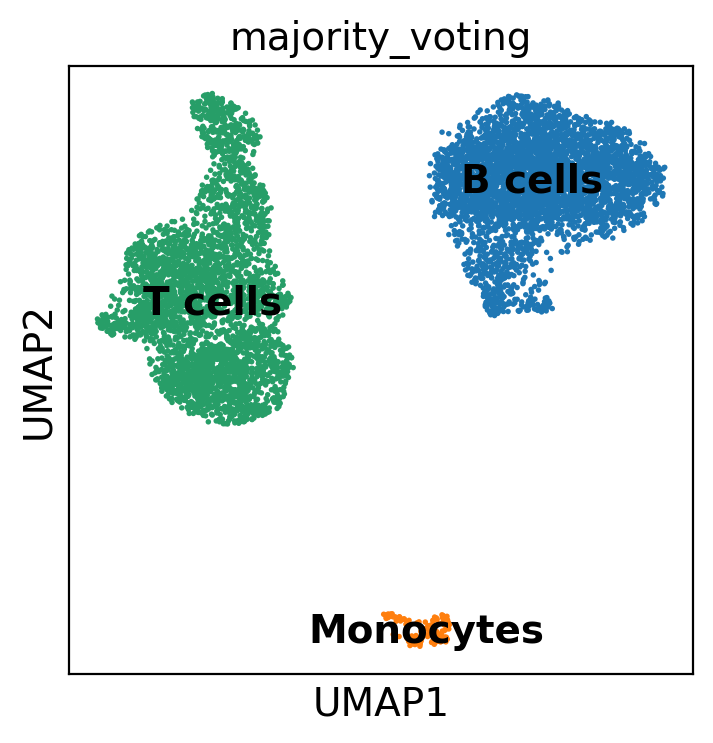

In [120]:
sc.pl.umap(adata, color = ['majority_voting'], legend_loc = 'on data')

In [124]:
Main_clustering = adata.obs['majority_voting']

In [126]:
predictions = celltypist.annotate(adata, model = 'Immune_All_Low.pkl', majority_voting = True)

🔬 Input data has 7654 cells and 16961 genes
🔗 Matching reference genes in the model
🧬 1810 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
👀 Detected a neighborhood graph in the input object, will run over-clustering on the basis of it
⛓️ Over-clustering input data with resolution set to 10
🗳️ Majority voting the predictions
✅ Majority voting done!


In [127]:
adata = predictions.to_adata()

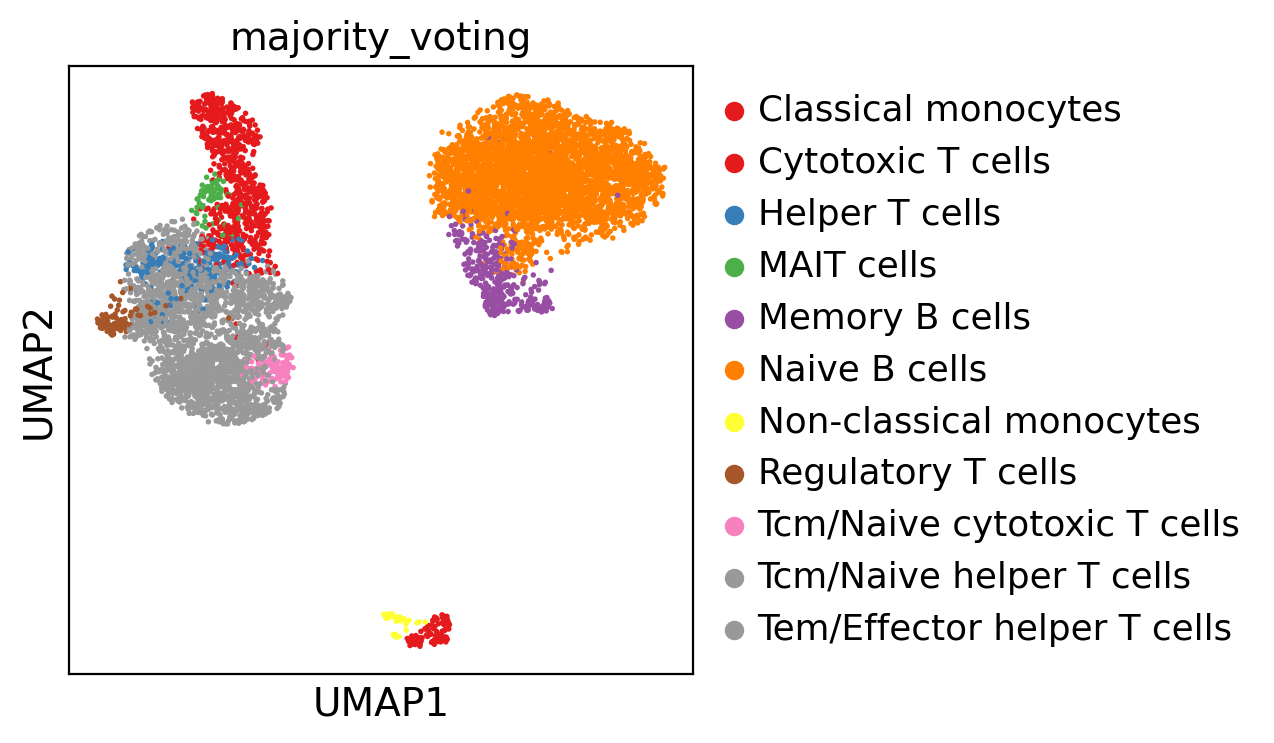

In [133]:
sc.pl.umap(adata, color = ['majority_voting'])

In [136]:
Minor_clustering = adata.obs['majority_voting']

In [137]:
adata.obs['Main_clustering'] = Main_clustering 
adata.obs['Minor_clustering'] = Minor_clustering 

#### Cluster frequency Main Type

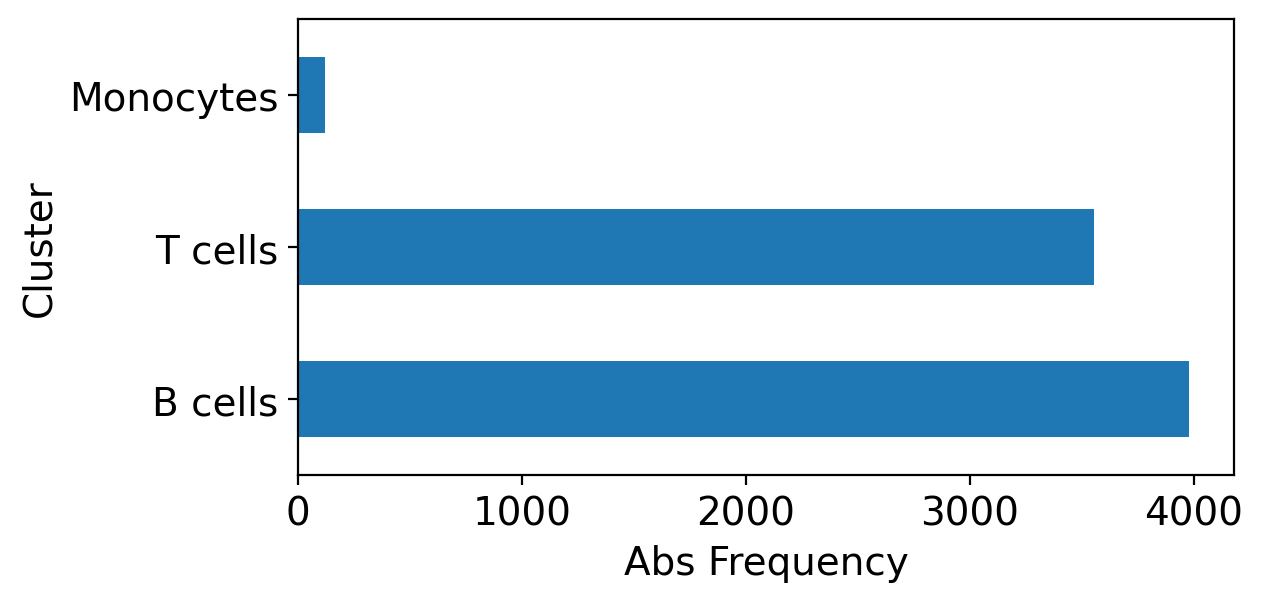

In [179]:
fig, (ax1) = plt.subplots(1,1, figsize=(6,3))
ax1 = adata.obs["Main_clustering"].value_counts().plot.barh(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Abs Frequency")
ax1.set_ylabel("Cluster")
ax1.grid(False)

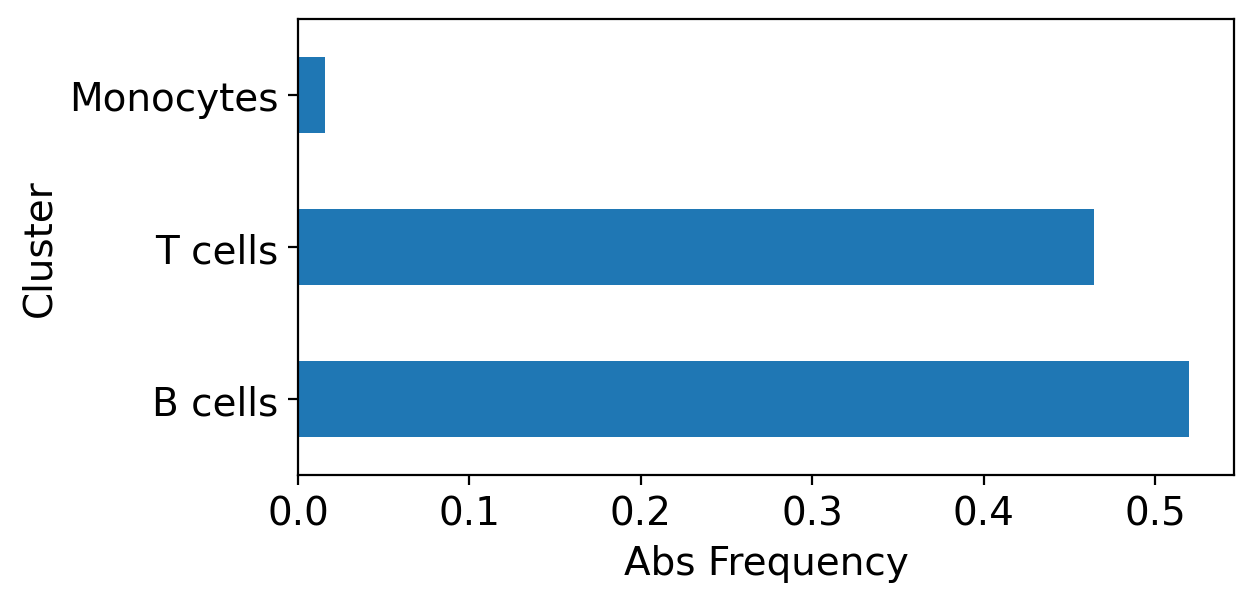

In [180]:
fig, (ax1) = plt.subplots(1,1, figsize=(6,3))
ax1 = adata.obs["Main_clustering"].value_counts(normalize=True).plot.barh(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Abs Frequency")
ax1.set_ylabel("Cluster")
ax1.grid(False)

#### Cluster frequency Minor Type

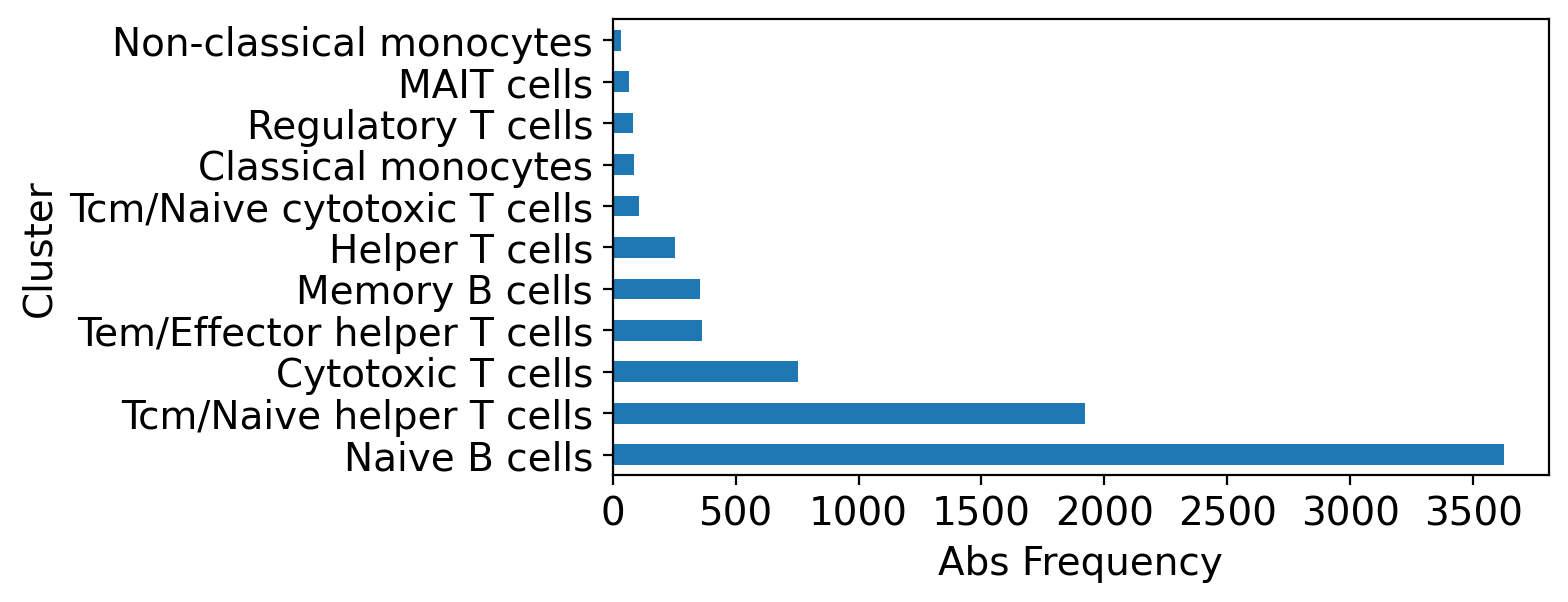

In [181]:
fig, (ax1) = plt.subplots(1,1, figsize=(6,3))
ax1 = adata.obs["Minor_clustering"].value_counts().plot.barh(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Abs Frequency")
ax1.set_ylabel("Cluster")
ax1.grid(False)


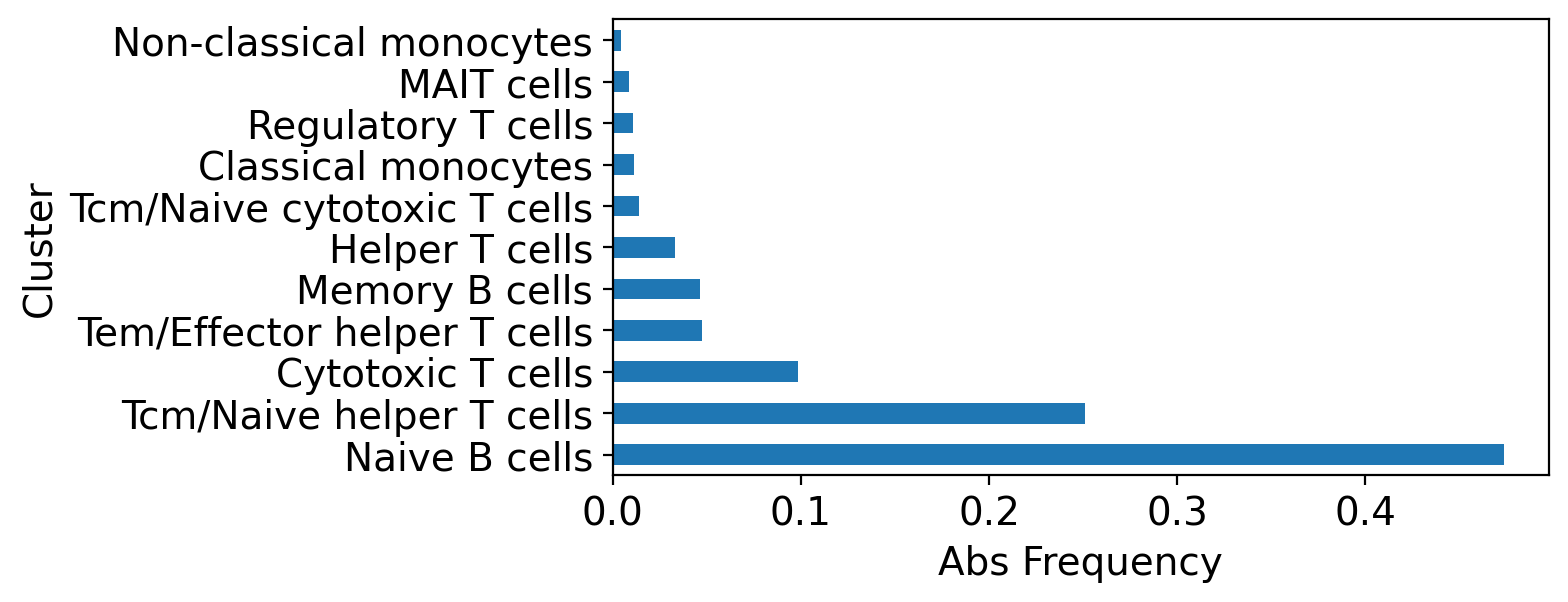

In [182]:
fig, (ax1) = plt.subplots(1,1, figsize=(6,3))
ax1 = adata.obs["Minor_clustering"].value_counts(normalize=True).plot.barh(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Abs Frequency")
ax1.set_ylabel("Cluster")
ax1.grid(False)


#### Differentially genes expression Main subset

In [165]:
sc.tl.rank_genes_groups(adata, groupby='Main_clustering', method='wilcoxon',layer="log1p",use_raw=False)

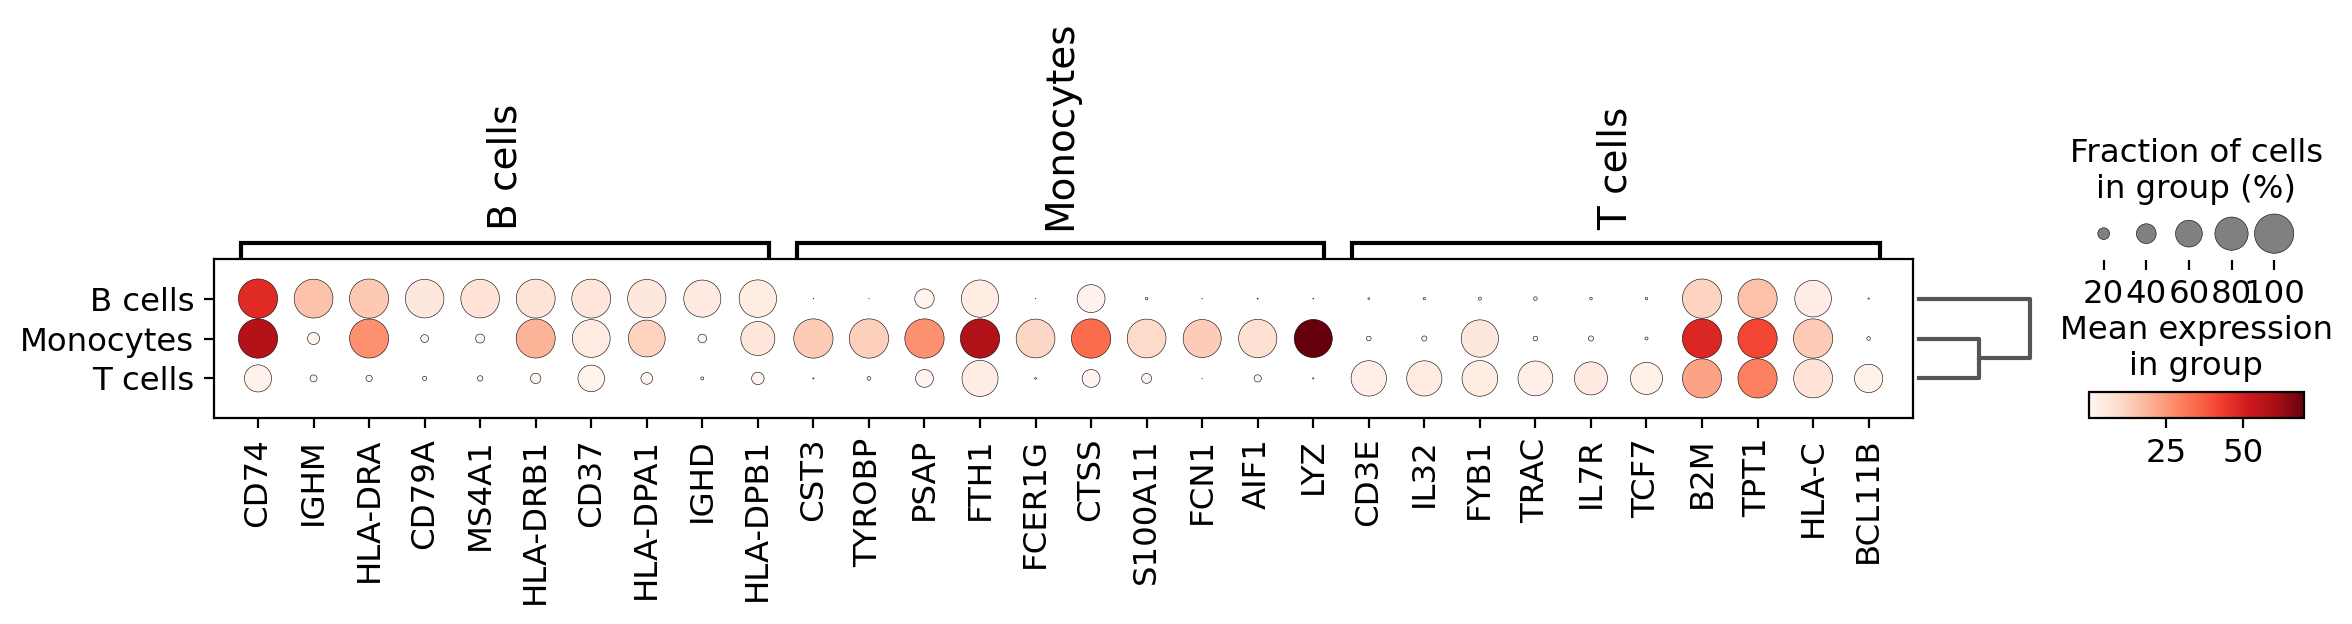

In [167]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10)

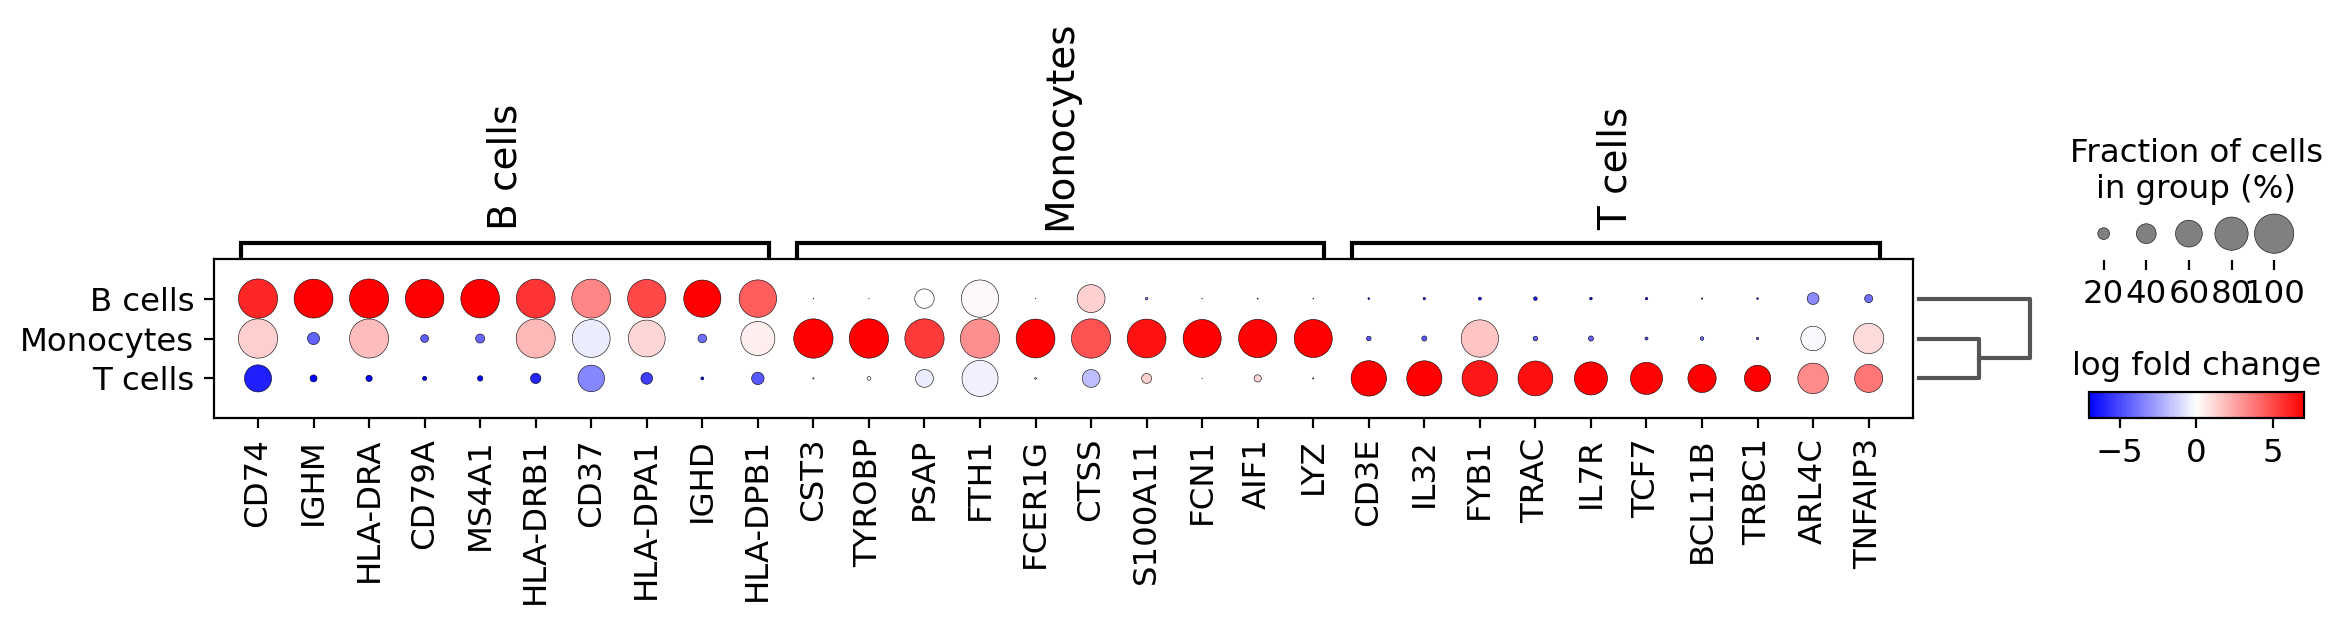

In [169]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=10, values_to_plot='logfoldchanges', min_logfoldchange=3, vmax=7, vmin=-7, cmap='bwr')

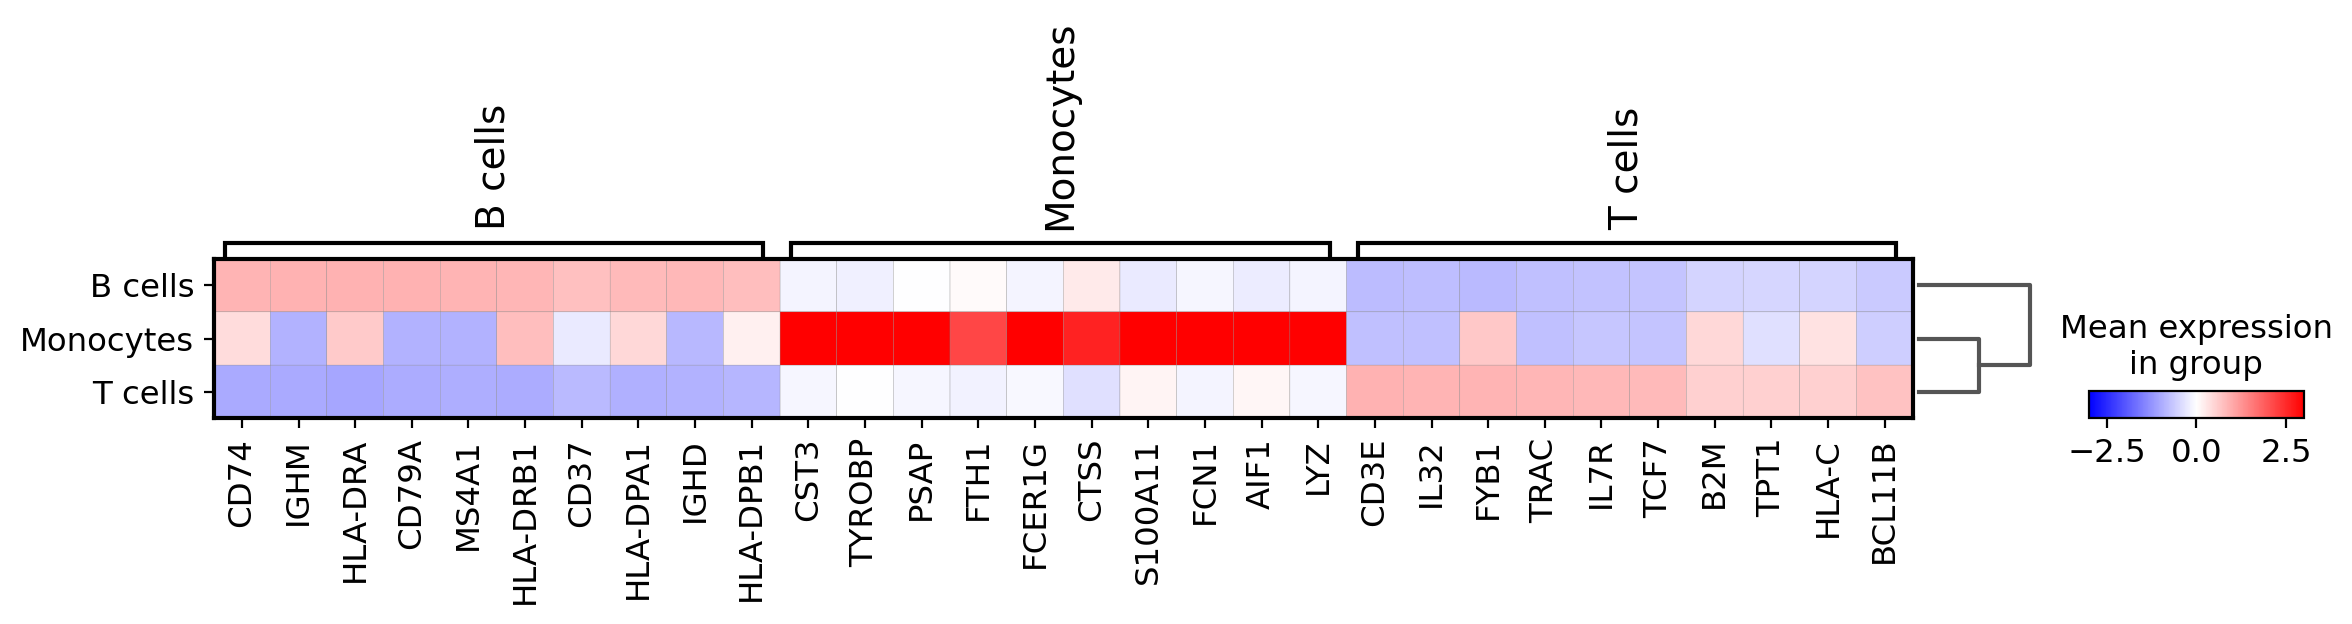

In [171]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=10, use_raw=False, vmin=-3, vmax=3, cmap='bwr', layer='scaled')

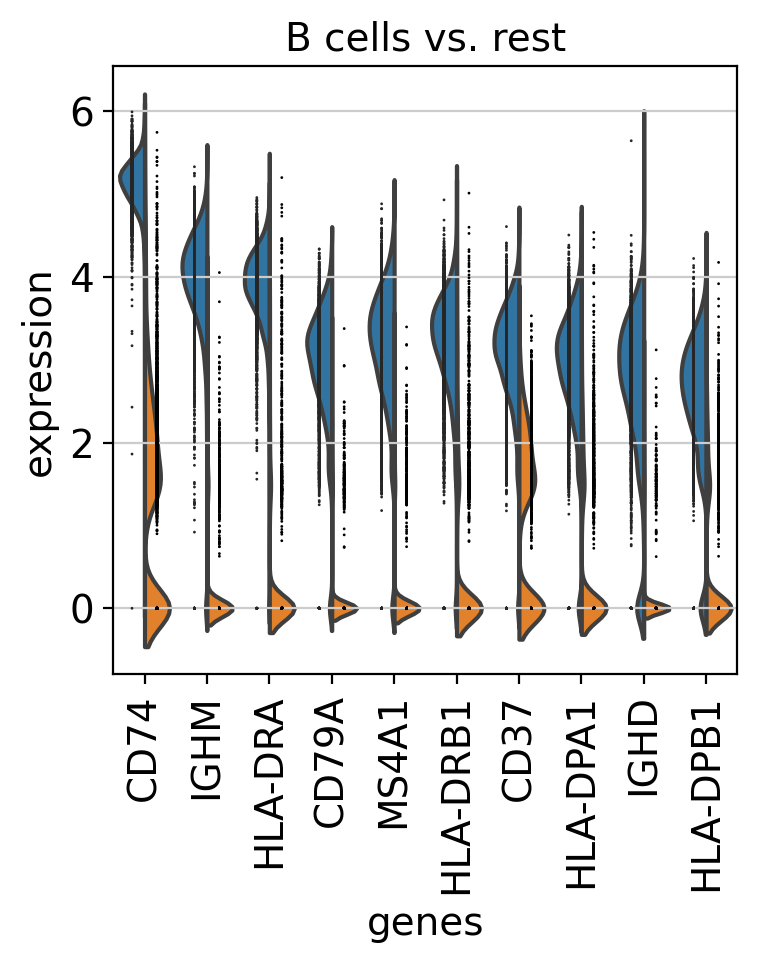

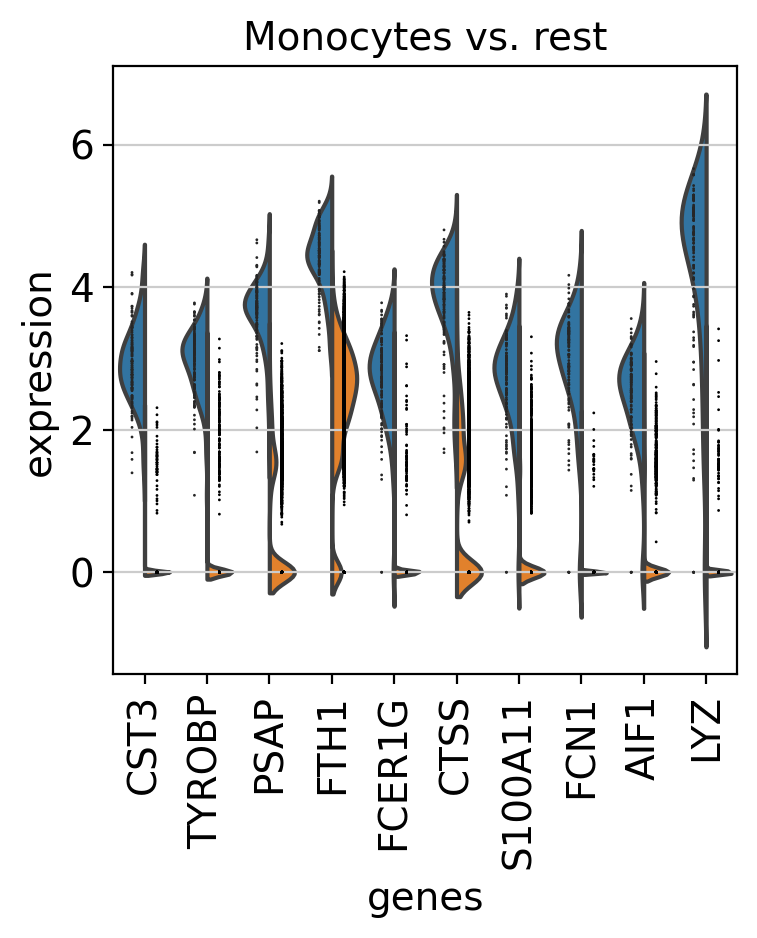

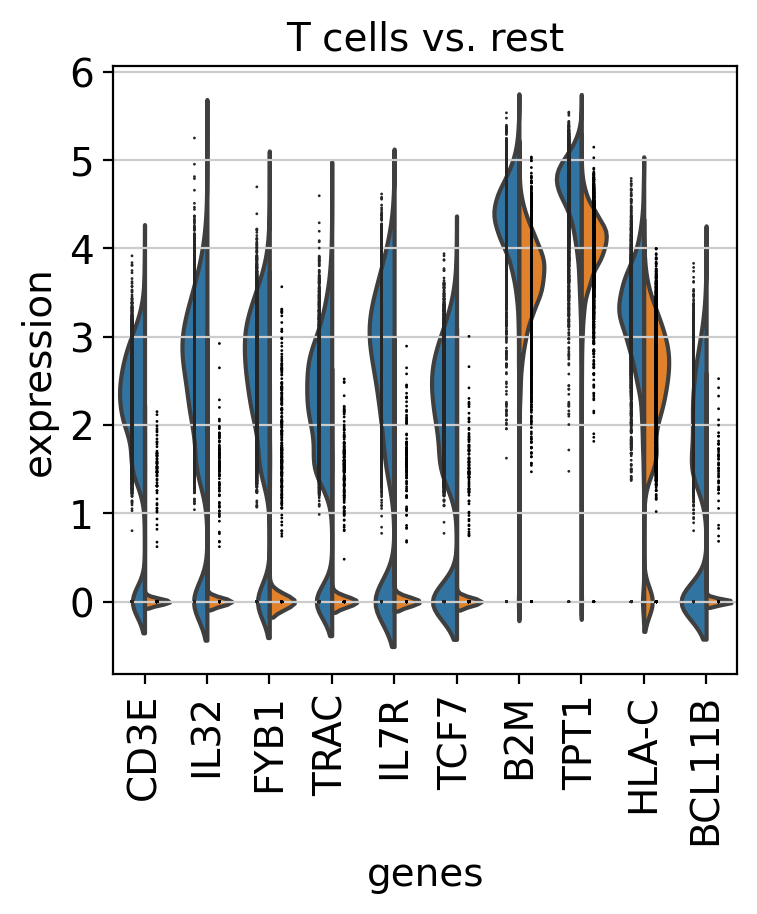

In [173]:
sc.pl.rank_genes_groups_violin(adata, n_genes=10, jitter=False)

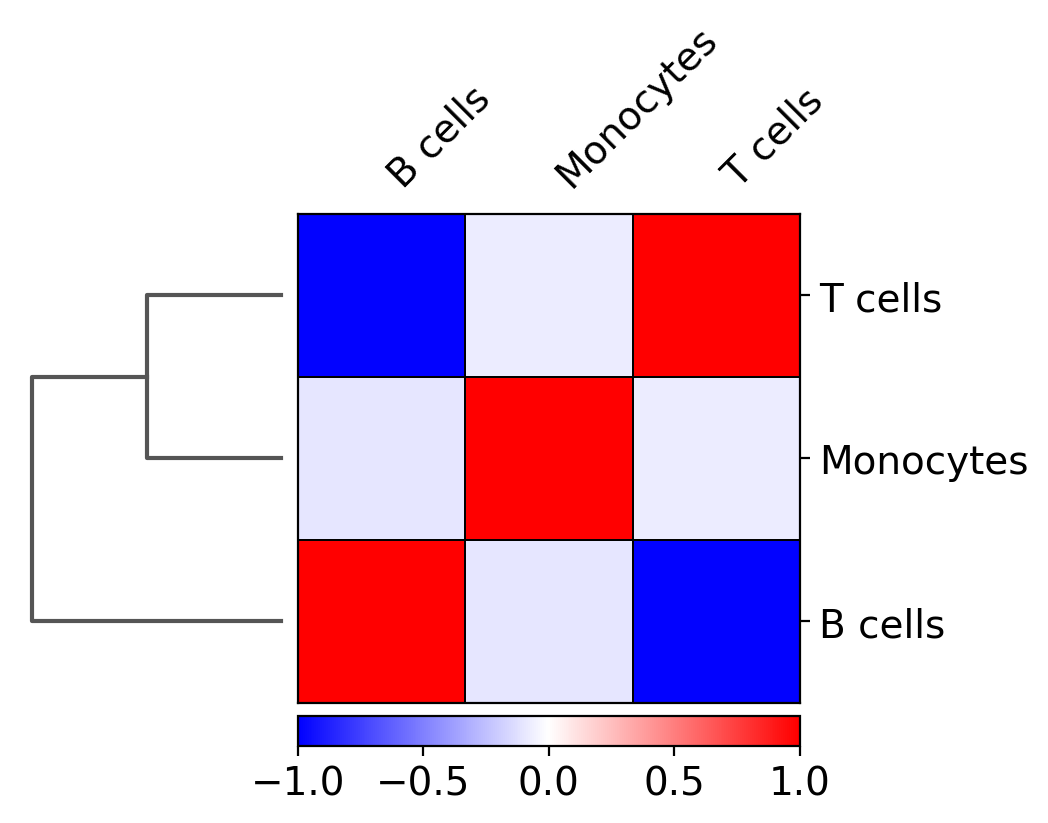

In [174]:
ax = sc.pl.correlation_matrix(adata, 'Main_clustering', figsize=(5,3.5))

In [175]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

B cells Monocytes  T cells
0       CD74      CST3     CD3E
1       IGHM    TYROBP     IL32
2    HLA-DRA      PSAP     FYB1
3      CD79A      FTH1     TRAC
4      MS4A1    FCER1G     IL7R
5   HLA-DRB1      CTSS     TCF7
6       CD37   S100A11      B2M
7   HLA-DPA1      FCN1     TPT1
8       IGHD      AIF1    HLA-C
9   HLA-DPB1       LYZ   BCL11B
10  HLA-DQB1       FTL    HLA-A
11   FAM129C  SERPINA1    TRBC2
12  HLA-DQA1       VIM    TRBC1
13      IGKC      ACTB    ARL4C
14   RALGPS2      SPI1   TMSB4X
15   HLA-DMB      LST1     ETS1
16      PAX5      SRGN  TNFAIP3
17      CD22    S100A6    RPS29
18  HLA-DRB5      KLF4     CD3D
19     BANK1    LILRB2     CD3G

In [176]:
result = adata.uns['rank_genes_groups']

In [183]:
groups = result['names'].dtype.names
with pd.ExcelWriter(outputpath+ '/MainSubset_DEGS.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(adata, group=groups[_], key='rank_genes_groups').to_excel(writer, sheet_name=groups[_],index=False)
        sc.get.rank_genes_groups_df(adata, group=groups[_], key='rank_genes_groups',pval_cutoff=0.05, log2fc_min=2).to_excel(writer, sheet_name="".join([groups[_],"_filtered"]),index=False)  

#### Differentially genes expression Minor subset

In [190]:
sc.tl.rank_genes_groups(adata, groupby='Minor_clustering', method='wilcoxon',layer="log1p",use_raw=False,pts=0.25)

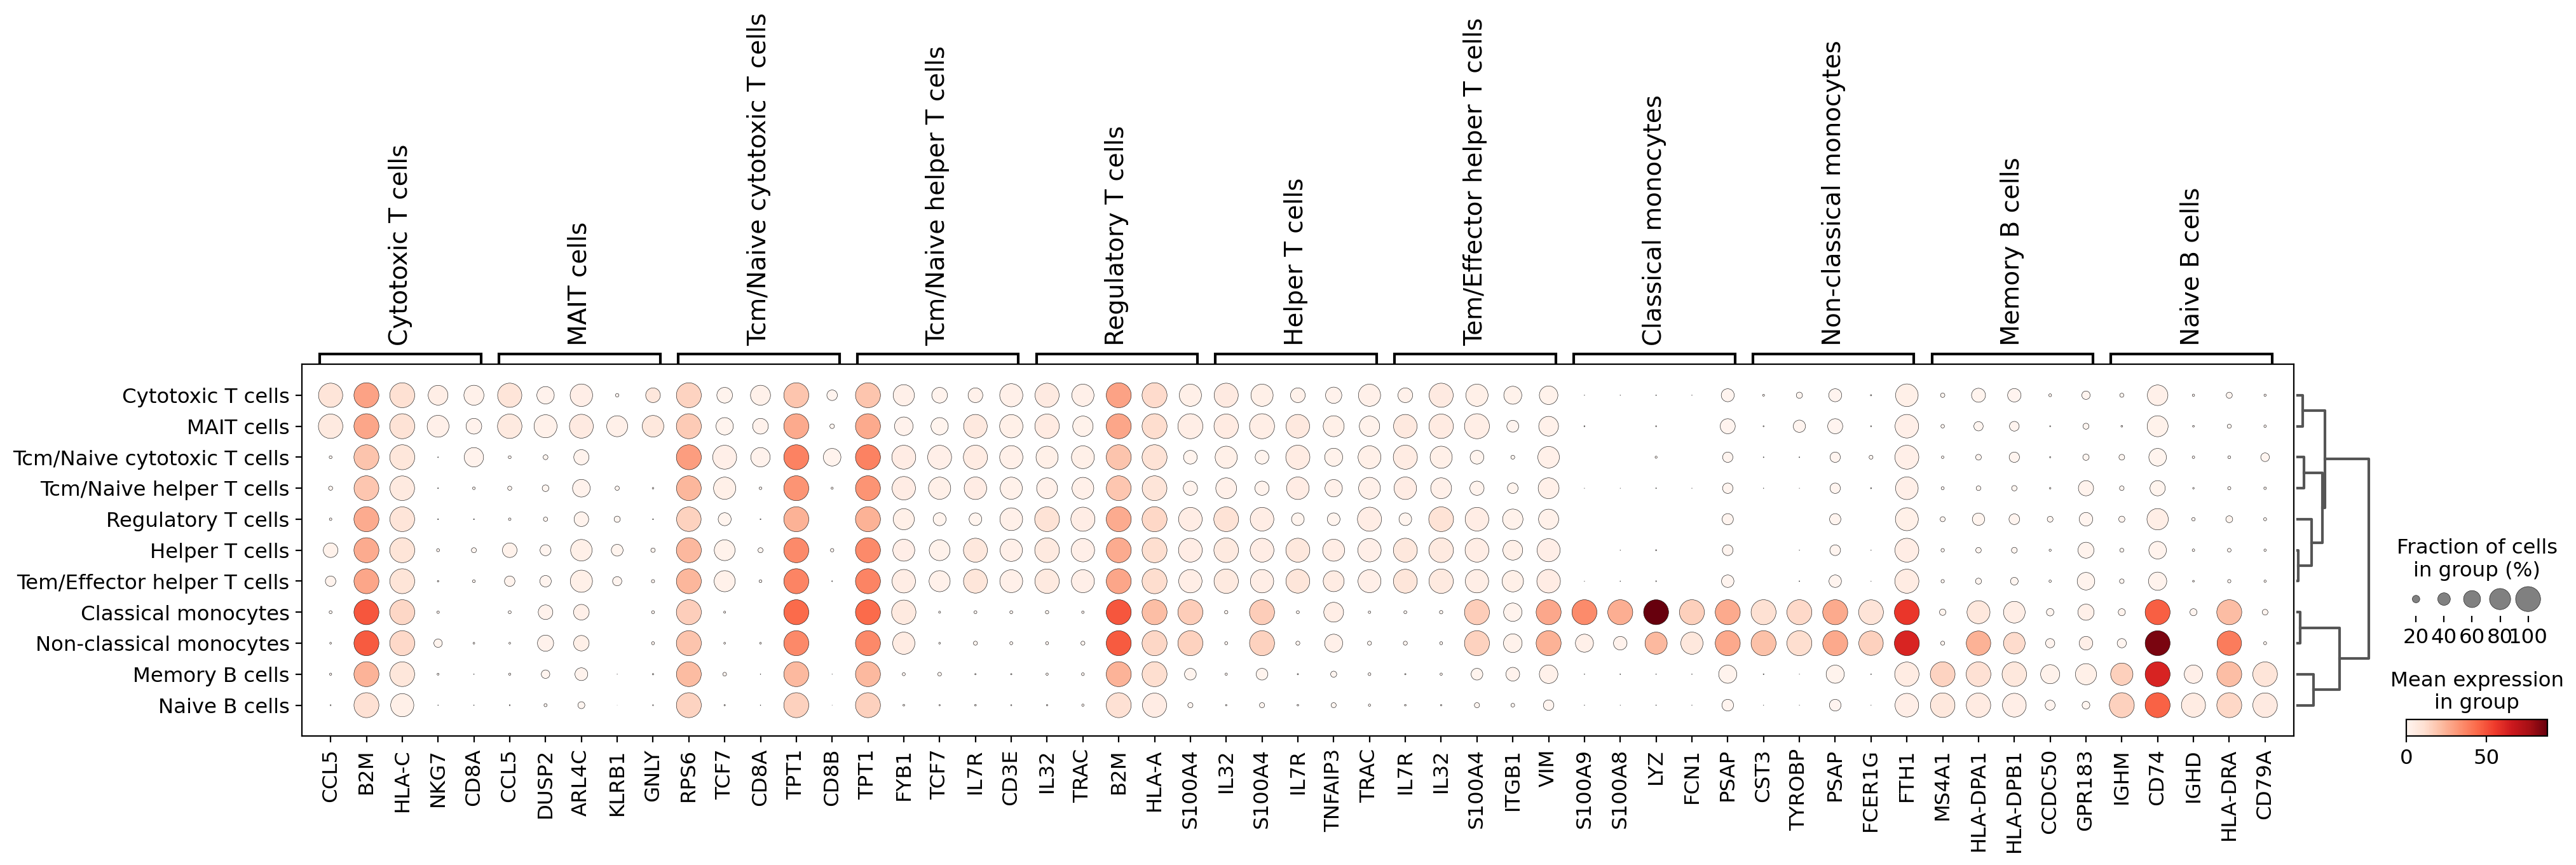

In [191]:
sc.pl.rank_genes_groups_dotplot(adata, n_genes=5)

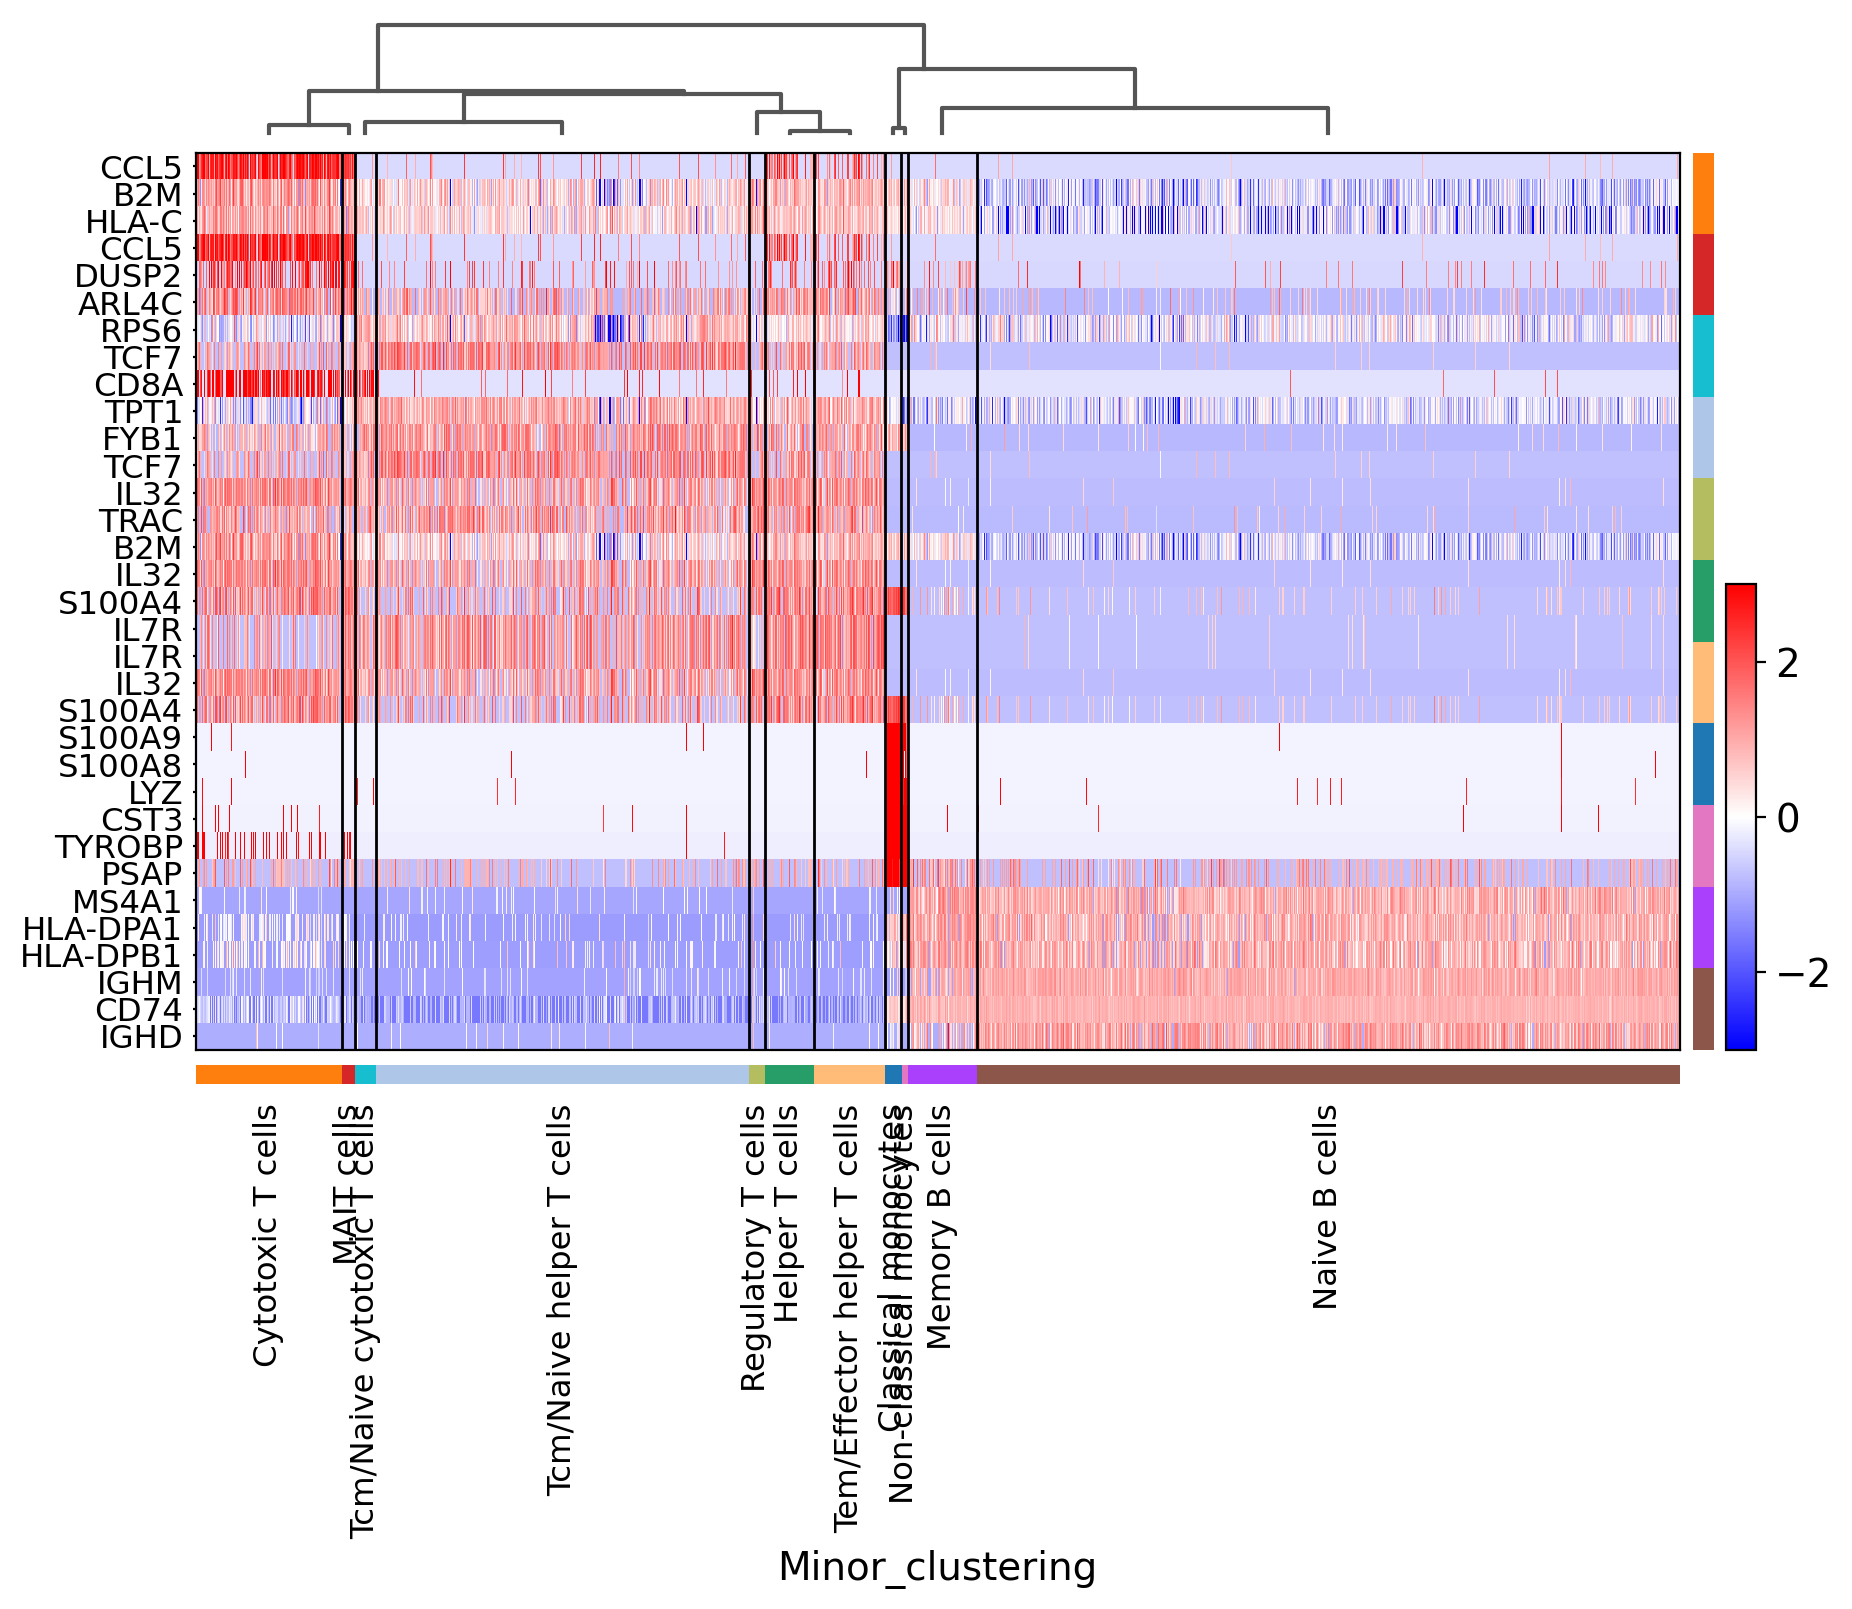

In [192]:
sc.pl.rank_genes_groups_heatmap(adata, n_genes=3, use_raw=False, swap_axes=True, vmin=-3, vmax=3, cmap='bwr', layer='scaled', figsize=(10,7), show=False);

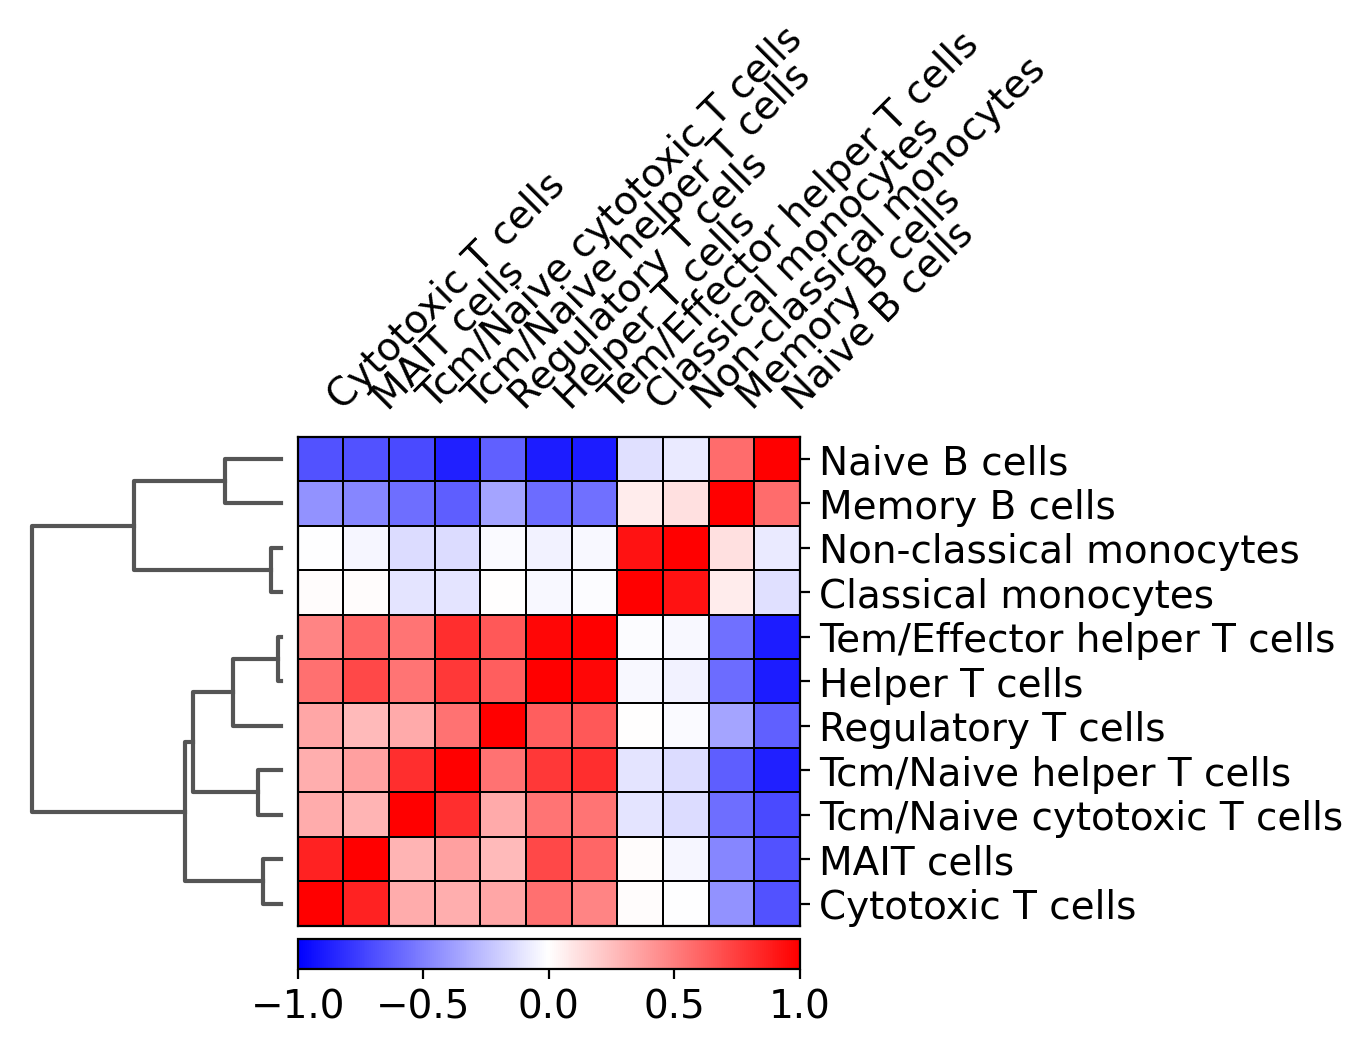

In [193]:
ax = sc.pl.correlation_matrix(adata, 'Minor_clustering', figsize=(5,3.5))

In [194]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(20)

Classical monocytes Cytotoxic T cells Helper T cells MAIT cells  \
0               S100A9              CCL5           IL32       CCL5   
1               S100A8               B2M         S100A4      DUSP2   
2                  LYZ             HLA-C           IL7R      ARL4C   
3                 FCN1              NKG7        TNFAIP3      KLRB1   
4                 PSAP              CD8A           TRAC       GNLY   
5               TYROBP              GZMA          ITGB1       NKG7   
6                 CST3              IL32            B2M     S100A4   
7                  FTL              CST7          AHNAK       GZMK   
8                 CTSS              CTSW           TPT1       GZMA   
9                 VCAN             HLA-A          ANXA1        B2M   
10                FTH1             ARL4C           RGCC       CST7   
11                CPVL             HLA-B          HLA-C       IL32   
12              MS4A6A              HCST          HLA-A      HLA-C   
13            SERPINA1              CD3E            VIM      SYNE2   
14              FCER1G            S100A4           CD3E       HCST   
15                CD14              SRGN          ARL4C        ID2   
16             S100A11             RUNX3        ZFP36L2       IL7R   
17                AIF1             DUSP2          CALM1       CD3E   
18                SRGN              TRAC        S100A10      AHNAK   
19                MNDA             ITGAL         EEF1A1       LYAR   

   Memory B cells Naive B cells Non-classical monocytes Regulatory T cells  \
0           MS4A1          IGHM                    CST3               IL32   
1        HLA-DPA1          CD74                  TYROBP               TRAC   
2        HLA-DPB1          IGHD                    PSAP                B2M   
3          CCDC50       HLA-DRA                  FCER1G              HLA-A   
4          GPR183         CD79A                    FTH1             S100A4   
5           BANK1          CD37                    LST1             TMSB4X   
6         HLA-DRA         MS4A1                    ACTB               ACTB   
7        HLA-DQA1      HLA-DRB1                   MS4A7              RTKN2   
8           CD79A      HLA-DPA1                 S100A11               PFN1   
9        HLA-DRB1      HLA-DQB1                    SPI1              TRBC1   
10       HLA-DQB1       FAM129C                    SAT1              HLA-C   
11          NEAT1      HLA-DPB1                     VIM             SAMHD1   
12         POU2F2      HLA-DQA1                    CTSS               CD3E   
13        RALGPS2       HLA-DMB                    AIF1              FOXP3   
14            SYK          IGKC                   COTL1               GBP5   
15       HLA-DRB5       RALGPS2                    KLF4              ITGB1   
16          FCRLA          PAX5                  LILRB2              CALM1   
17           CD74          CD22                  LRRC25             SPOCK2   
18           TCF4      HLA-DRB5                    WARS              GAPDH   
19           IGKC         MEF2C                     FTL               ETS1   

   Tcm/Naive cytotoxic T cells Tcm/Naive helper T cells  \
0                         RPS6                     TPT1   
1                         TCF7                     FYB1   
2                         CD8A                     TCF7   
3                         TPT1                     IL7R   
4                         CD8B                     CD3E   
5                        RPL32                    RPL31   
6                        RPS14                     TRAC   
7                       EEF1A1                   BCL11B   
8                        RPL34                    RPS29   
9                        RPS12                     RPS6   
10                       RPS3A                    RPL32   
11                        FYB1                     LEF1   
12                       RPS29                    RPS14   
13                        IL7R                    RPL34   
14      

In [195]:
result = adata.uns['rank_genes_groups']

#### Export files

In [202]:
groups = result['names'].dtype.names
with pd.ExcelWriter(outputpath+ '/MinorSubset_DEGS.xlsx') as writer:
    for _ in range(len(groups)):
        sc.get.rank_genes_groups_df(adata, group=groups[_], key='rank_genes_groups').to_excel(writer, sheet_name=str(groups[_]).replace("/", " "),index=False)
        sc.get.rank_genes_groups_df(adata, group=groups[_], key='rank_genes_groups',pval_cutoff=0.05, log2fc_min=2).to_excel(writer, sheet_name="".join([str(groups[_]).replace("/", " "),"_filtered"]),index=False)  

In [204]:
adata.write("/mnt/lugli/spuccio/SP025_NaClTcell/singlecell/Analysis/scNov/anndata_obj.h5ad")